#Author
Nama : `Fajar Arahman`

Di dalam notebook ini, berfokus pada training dan testing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [88]:
!pip install mmlspark

ERROR: Could not find a version that satisfies the requirement mmlspark (from versions: none)
ERROR: No matching distribution found for mmlspark


In [99]:
import pandas as pd
import numpy as np
import pycaret

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as ltb

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##Load Dataset

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv', sep=',')
df_test = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_test.csv',sep=',')
print('Jumlah dataset %d baris dan %d kolom.\n' % df_train.shape)

Jumlah dataset 307511 baris dan 122 kolom.



In [6]:
df_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Target 0 dan 1 merupakan kemampuan membayar pinjaman
* 0 Untuk tidak mempunyai kesulitan bayar
* 1 Untuk mempunyai kesulitan bayar

In [7]:
df_train.duplicated().sum()

0

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Analisa:


*   Jumlah dataset yaitu 307,511 baris dan 122 kolom
*   Dataset tidak ada yang duplikat
*   Kolom Target menjadi Feature untuk LABEL yang akan diprediksi dengan asumsi nilai 0 adalah berhasil bayar dan nilai 1 adalah gagal bayar
* Kolom SK_ID_CURR merupakan kode unik untuk setiap nasabah



## Exploratory Data Analysis (EDA)

###Check Data Types

In [9]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

<b> 65 kolom tipe data float </b> <br/>
<b> 41 kolom tipe data integer </b> <br/>
<b> 16 kolom tipe data object </b> <br/>

###Statistics

In [10]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


##Univariate
Gunakan visualisasi untuk melihat distribusi masing-masing kolom (feature maupun
target). Tuliskan hasil observasinya, misalnya jika ada suatu kolom yang distribusinya
menarik (misal skewed, bimodal, ada outlier, ada nilai yang mendominasi, kategorinya
terlalu banyak, dsb). Jelaskan juga apa yang harus di-follow up saat data pre-processing.

In [11]:
train = df_train.copy()

In [12]:
decode_map = {0 : 'No Payment Issues', 1 : 'Payment Issues'}
def decode_target(label):
  return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_target(x))

In [13]:
target_grp = (train[['TARGET']]
              .groupby("TARGET")
              .agg(COUNT=("TARGET","count"))
              .sort_values(by=["COUNT"], ascending=False)
              .reset_index()
              )
target_grp

,TARGET,COUNT
0,No Payment Issues,282686
1,Payment Issues,24825


In [14]:
target_percent = (train['TARGET'].value_counts()/len(train)*100)
target_percent.reset_index()
target_percent

No Payment Issues    91.927118
Payment Issues        8.072882
Name: TARGET, dtype: float64

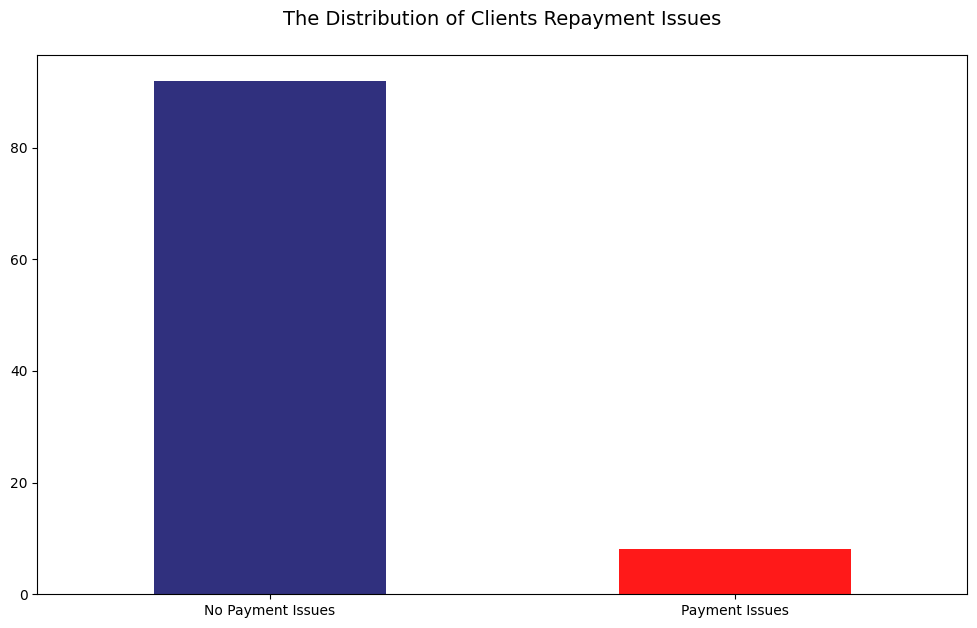

In [15]:
fig = plt.figure(figsize = (12,7))
target_percent.plot(kind='bar', color= ['midnightblue','red'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Issues\n', fontsize=14)
plt.show()

Ada 91% atau sama dengan 282K dengan target 0, ini berindikasi bahwa client tidak mempunyai masalah untuk pembayaran peminjaman. Dan 9% sisanya atau sekitar 24K memiliki masalah pembayaran peminjaman

**Note** : Dataset ini merupakan imbalance dan memerluhkan penanganan untuk mempertinggi akurasi model saat pre-processing. Bisa menggunakan SMOTEK

###Bivariate: Categorical Features vs Target

Gender,Contract_Type,Car Ownership, Realty Ownership

<Axes: title={'center': 'Clients Repayment Issues by Realty Ownership\n'}, xlabel='FLAG_OWN_REALTY', ylabel='count'>

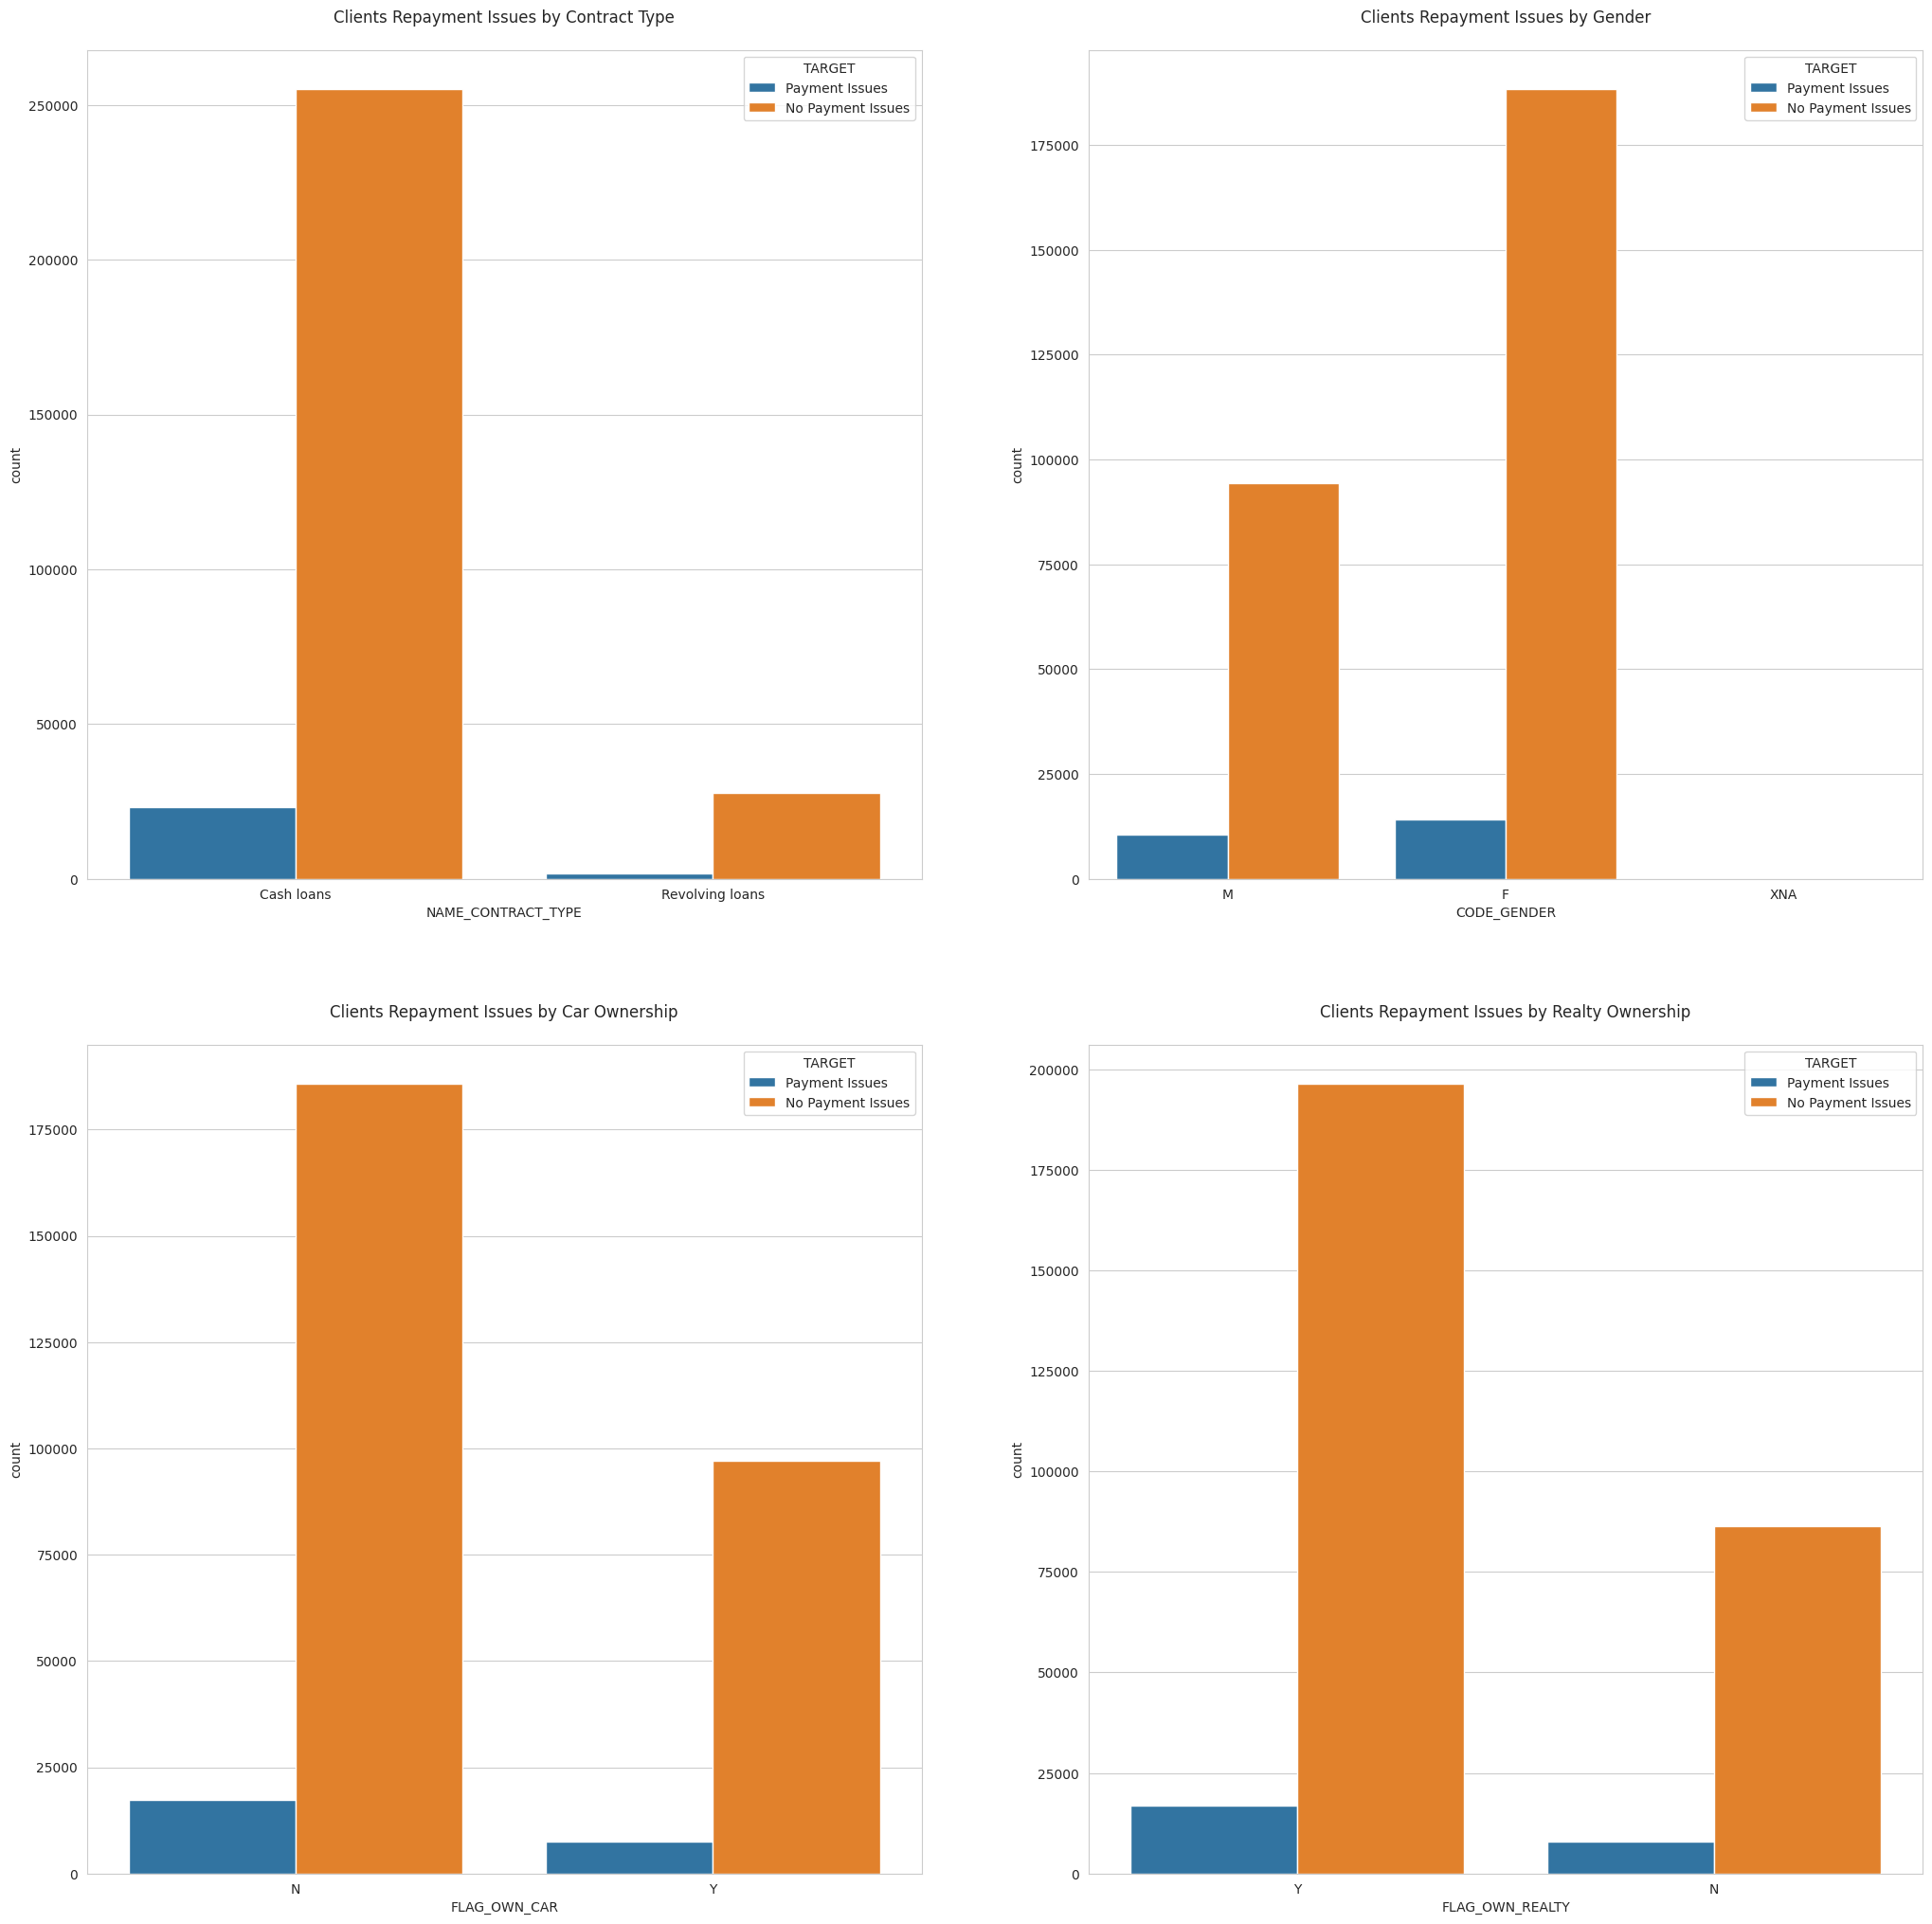

In [16]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(2,2, figsize=(25,25))

ax[0][0].set_title('Clients Repayment Issues by Contract Type\n')
sns.countplot(x='NAME_CONTRACT_TYPE', data = train, hue ='TARGET', ax=ax[0][0])
ax[0][1].set_title('Clients Repayment Issues by Gender\n')
sns.countplot(x='CODE_GENDER', data = train, hue ='TARGET', ax=ax[0][1])
ax[1][0].set_title('Clients Repayment Issues by Car Ownership\n')
sns.countplot(x='FLAG_OWN_CAR', data = train, hue ='TARGET', ax=ax[1][0])
ax[1][1].set_title('Clients Repayment Issues by Realty Ownership\n')
sns.countplot(x='FLAG_OWN_REALTY', data = train, hue ='TARGET', ax=ax[1][1])


####Gender vs Target

In [17]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['F','M'],['Female','Male'])
gt = train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Issues By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)
gt.rename(columns = {'SK_ID_CURR': 'Total'}, inplace=True)
gt.style.background_gradient(cmap='Blues')

Clients Repayment Issues By Gender


,CODE_GENDER,TARGET,Total
0,Female,No Payment Issues,188278
1,Female,Payment Issues,14170
2,Male,No Payment Issues,94404
3,Male,Payment Issues,10655
4,XNA,No Payment Issues,4


In [18]:
df_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


**Hasil Analisa**
* Gagal bayar terjadi pada gender laki-laki sebanyak 10% dari total dan menjadi paling tinggi gagal bayar berdasarkan gender
* Gagal bayar terjadi pada gender perempuan sebesar 7%
* Terdapat Gender XNA yang mungkin akan kita delete saja

####Contract Type vs Target

In [19]:
ct = train.groupby(by=['TARGET','NAME_CONTRACT_TYPE'], as_index=True) ['CODE_GENDER'].count().reset_index().sort_values(by="NAME_CONTRACT_TYPE")
ct.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
ct.sort_values(by='Customers',ascending=False)

name_of_ct = list(ct['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_of_ct:
    data = ct[ct['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ct['Percent'] = percentage
ct

,TARGET,NAME_CONTRACT_TYPE,Customers,Percent
0,No Payment Issues,Cash loans,255011,0.92
2,Payment Issues,Cash loans,23221,0.08
1,No Payment Issues,Revolving loans,27675,0.95
3,Payment Issues,Revolving loans,1604,0.05


* **Cash loans** dengan perkiraan 278K pinjaman menjadi favorit untuk para peminjam
* **Revolving Loans** memiliki 29K pinjaman menjadi terendah untuk jenis pinjaman


####Car Ownership Status vs Target

In [20]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [21]:
cr = train.groupby(by=['TARGET','FLAG_OWN_CAR'], as_index=True) ['CODE_GENDER'].count().reset_index().sort_values(by="FLAG_OWN_CAR")
cr.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
cr.sort_values(by='FLAG_OWN_CAR',ascending=False)

name_of_cr = list(cr['FLAG_OWN_CAR'].unique())
percentage = []

for i in name_of_cr:
    data = cr[cr['FLAG_OWN_CAR'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

cr['Percent'] = percentage
cr

,TARGET,FLAG_OWN_CAR,Customers,Percent
0,No Payment Issues,No,185675,0.91
2,Payment Issues,No,17249,0.09
1,No Payment Issues,Yes,97011,0.93
3,Payment Issues,Yes,7576,0.07


Peminjam paling banyak tidak mempunyai mobil

Peminjman yang mempunyai **mobil** sekitar 7% memiliki masalah saat pembayaran dan dibandingkan client yang tidak mempunyai mobil sekitar 9%. Perbedaan yang tidak signifikan

####Realty Ownership Status vs Target

In [22]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [23]:
rt = train.groupby(by=['TARGET','FLAG_OWN_REALTY'], as_index=True) ['CODE_GENDER'].count().reset_index().sort_values(by="FLAG_OWN_REALTY")
rt.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
rt.sort_values(by='FLAG_OWN_REALTY',ascending=False)

name_of_rt = list(rt['FLAG_OWN_REALTY'].unique())
percentage = []

for i in name_of_rt:
    data = rt[rt['FLAG_OWN_REALTY'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

rt['Percent'] = percentage
rt

,TARGET,FLAG_OWN_REALTY,Customers,Percent
0,No Payment Issues,No,86357,0.92
2,Payment Issues,No,7842,0.08
1,No Payment Issues,Yes,196329,0.92
3,Payment Issues,Yes,16983,0.08


Kebanyakan peminjam mempunyai rumah

Peminjam yang mempunyai **rumah** sebanyak 8% memiliki masalah pembayaran begitu juga yang tidak mempunyai rumah yaitu 8%.

###Suite Type, Income Type, Education Type, and Family Status

<Axes: title={'center': '\nClients Repayment Abilities By Family Status\n'}, xlabel='NAME_FAMILY_STATUS', ylabel='count'>

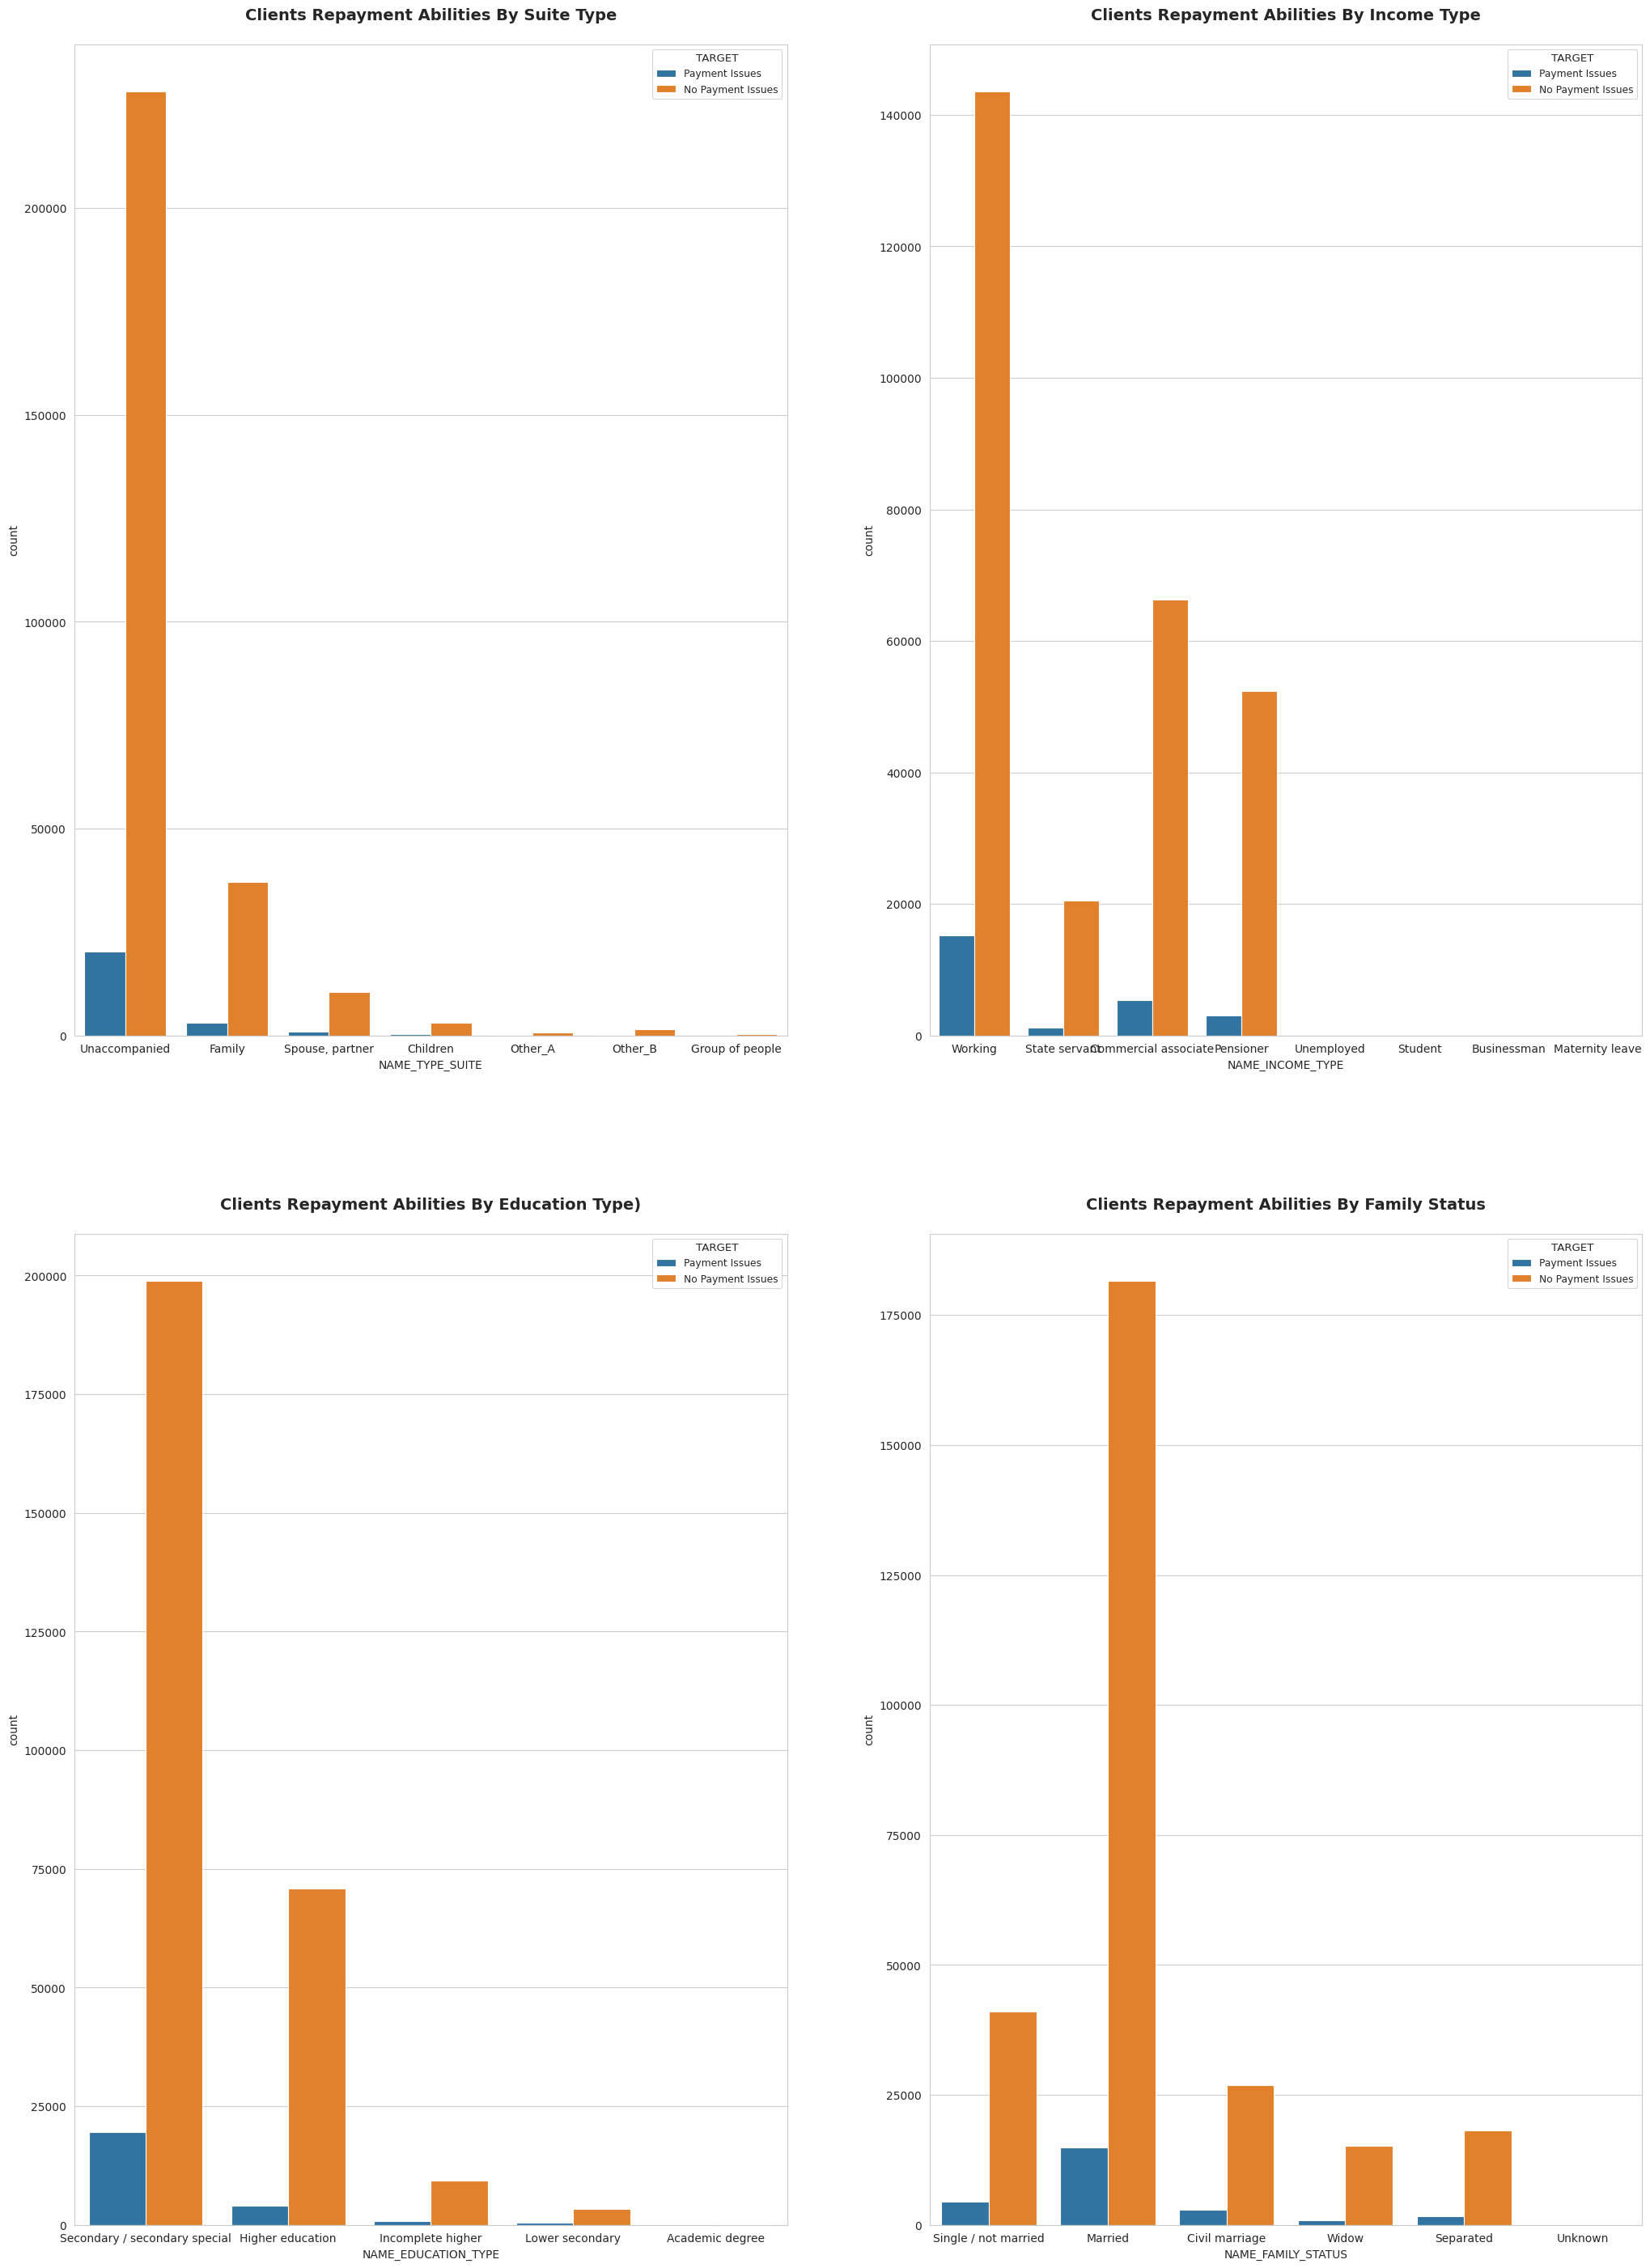

In [24]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE', data = train, hue = 'TARGET', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE', data = train, hue = 'TARGET', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE', data = train, hue = 'TARGET', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_FAMILY_STATUS', data = train, hue = 'TARGET', ax=ax[1][1])

####Suite Type vs Target

In [25]:
st = train.groupby(by=['TARGET','NAME_TYPE_SUITE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="NAME_TYPE_SUITE")
st.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
st.sort_values(by='NAME_TYPE_SUITE',ascending=False)

name_of_st = list(st['NAME_TYPE_SUITE'].unique())
percentage = []

for i in name_of_st:
    data = st[st['NAME_TYPE_SUITE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

st['Percent'] = percentage
st

,TARGET,NAME_TYPE_SUITE,Customers,Percent
0,No Payment Issues,Children,3026,0.93
7,Payment Issues,Children,241,0.07
1,No Payment Issues,Family,37140,0.93
8,Payment Issues,Family,3009,0.07
2,No Payment Issues,Group of people,248,0.92
9,Payment Issues,Group of people,23,0.08
3,No Payment Issues,Other_A,790,0.91
10,Payment Issues,Other_A,76,0.09
4,No Payment Issues,Other_B,1596,0.90
11,Payment Issues,Other_B,174,0.10


Peminjam yang ditemani oleh **other_b** menjadi paling gagal bayar sekitar 10%

####Income Type vs Target

In [26]:
it = train.groupby(by=['TARGET','NAME_INCOME_TYPE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="NAME_INCOME_TYPE")
it.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
it.sort_values(by='NAME_INCOME_TYPE',ascending=False)

name_of_it = list(it['NAME_INCOME_TYPE'].unique())
percentage = []

for i in name_of_it:
    data = it[it['NAME_INCOME_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

it['Percent'] = percentage
it

,TARGET,NAME_INCOME_TYPE,Customers,Percent
0,No Payment Issues,Businessman,10,1.00
1,No Payment Issues,Commercial associate,66257,0.93
8,Payment Issues,Commercial associate,5360,0.07
2,No Payment Issues,Maternity leave,3,0.60
9,Payment Issues,Maternity leave,2,0.40
3,No Payment Issues,Pensioner,52380,0.95
10,Payment Issues,Pensioner,2982,0.05
4,No Payment Issues,State servant,20454,0.94
11,Payment Issues,State servant,1249,0.06
5,No Payment Issues,Student,18,1.00


Peminjam terbanyak dari hasil pendapatan yaitu pada tipe **Working** dengan jumlah 158,774 peminjman

Peminjman dengan tipe businessman dan student tidak memiliki masalah saat pembayaran

Sedangkan, peminjam dengan pendapatan tipe Maternity Leaves dan Unemployed menjadi tertinggi untuk gagal bayar sebanyak (40% dan 36%)

####Education Type vs Target

In [27]:
et = train.groupby(by=['TARGET','NAME_EDUCATION_TYPE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="NAME_EDUCATION_TYPE")
et.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
et.sort_values(by='NAME_EDUCATION_TYPE',ascending=False)

name_of_et = list(et['NAME_EDUCATION_TYPE'].unique())
percentage = []

for i in name_of_et:
    data = et[et['NAME_EDUCATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

et['Percent'] = percentage
et

,TARGET,NAME_EDUCATION_TYPE,Customers,Percent
0,No Payment Issues,Academic degree,161,0.98
5,Payment Issues,Academic degree,3,0.02
1,No Payment Issues,Higher education,70854,0.95
6,Payment Issues,Higher education,4009,0.05
2,No Payment Issues,Incomplete higher,9405,0.92
7,Payment Issues,Incomplete higher,872,0.08
3,No Payment Issues,Lower secondary,3399,0.89
8,Payment Issues,Lower secondary,417,0.11
4,No Payment Issues,Secondary / secondary special,198867,0.91
9,Payment Issues,Secondary / secondary special,19524,0.09


Tipe tertinggi untuk edukasi yaitu ada pada Secondary/ Secondary Special dengan jumlah 218K dan posisi kedua tipe edukasi dengan higher education berjumlah 75K

Untuk peminjam yang memiliki tingkat gagal bayar paling tinggi yaitu **lower secondary** dengan persentasei 10%

####Family Status Vs Target

In [28]:
fst = train.groupby(by=['TARGET','NAME_FAMILY_STATUS'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="NAME_FAMILY_STATUS")
fst.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
fst.sort_values(by='NAME_FAMILY_STATUS',ascending=False)

name_of_fst = list(fst['NAME_FAMILY_STATUS'].unique())
percentage = []

for i in name_of_fst:
    data = fst[fst['NAME_FAMILY_STATUS'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

fst['Percent'] = percentage
fst

,TARGET,NAME_FAMILY_STATUS,Customers,Percent
0,No Payment Issues,Civil marriage,26814,0.90
6,Payment Issues,Civil marriage,2961,0.10
1,No Payment Issues,Married,181582,0.92
7,Payment Issues,Married,14850,0.08
2,No Payment Issues,Separated,18150,0.92
8,Payment Issues,Separated,1620,0.08
3,No Payment Issues,Single / not married,40987,0.90
9,Payment Issues,Single / not married,4457,0.10
4,No Payment Issues,Unknown,2,1.00
5,No Payment Issues,Widow,15151,0.94


Peminjam tertinggi pada tipe **Married** dengan jumlah 196,432 peminjam

Tingkat gagal bayar tertinggi pada peminjam dengan tipe **Civil Marriage** dan **Single** dengan persentase 10%

###Housing Type, Occupation Type, Process Day, and Organization Type

####Housing Type

In [29]:
ht = train.groupby(by=['TARGET','NAME_HOUSING_TYPE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="NAME_HOUSING_TYPE")
ht.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
ht.sort_values(by='NAME_HOUSING_TYPE',ascending=False)

name_of_ht = list(ht['NAME_HOUSING_TYPE'].unique())
percentage = []

for i in name_of_ht:
    data = ht[ht['NAME_HOUSING_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ht['Percent'] = percentage
ht

,TARGET,NAME_HOUSING_TYPE,Customers,Percent
0,No Payment Issues,Co-op apartment,1033,0.92
6,Payment Issues,Co-op apartment,89,0.08
1,No Payment Issues,House / apartment,251596,0.92
7,Payment Issues,House / apartment,21272,0.08
2,No Payment Issues,Municipal apartment,10228,0.91
8,Payment Issues,Municipal apartment,955,0.09
3,No Payment Issues,Office apartment,2445,0.93
9,Payment Issues,Office apartment,172,0.07
4,No Payment Issues,Rented apartment,4280,0.88
10,Payment Issues,Rented apartment,601,0.12


Peminjam paling banyak berada di tipe **House/apartment** sebanyak 272K

Peminjam yang memiliki tingkat bayar paling tinggi adalah tipe **Rented Apartment** dan **With Parents** sekitar 12%

####Occupation Type

In [30]:
ot = train.groupby(by=['TARGET','OCCUPATION_TYPE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="OCCUPATION_TYPE")
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
ot.sort_values(by='OCCUPATION_TYPE',ascending=False)

name_of_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_of_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['Percent'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,Percent
0,No Payment Issues,Accountants,9339,0.95
18,Payment Issues,Accountants,474,0.05
1,No Payment Issues,Cleaning staff,4206,0.90
19,Payment Issues,Cleaning staff,447,0.10
2,No Payment Issues,Cooking staff,5325,0.90
20,Payment Issues,Cooking staff,621,0.10
21,Payment Issues,Core staff,1738,0.06
3,No Payment Issues,Core staff,25832,0.94
22,Payment Issues,Drivers,2107,0.11
4,No Payment Issues,Drivers,16496,0.89


Peminjam terbanyak dari tipe Laborers

Peminjam dengan gagal bayar tertinggi pada tipe **Low Skill laborers** dengan persentase 17%

####Process Day vs Target

In [31]:
pt = train.groupby(by=['TARGET','WEEKDAY_APPR_PROCESS_START'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="WEEKDAY_APPR_PROCESS_START")
pt.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
pt.sort_values(by='WEEKDAY_APPR_PROCESS_START',ascending=False)

name_of_pt = list(pt['WEEKDAY_APPR_PROCESS_START'].unique())
percentage = []

for i in name_of_pt:
    data = pt[pt['WEEKDAY_APPR_PROCESS_START'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

pt['Percent'] = percentage
pt

,TARGET,WEEKDAY_APPR_PROCESS_START,Customers,Percent
0,No Payment Issues,FRIDAY,46237,0.92
7,Payment Issues,FRIDAY,4101,0.08
1,No Payment Issues,MONDAY,46780,0.92
8,Payment Issues,MONDAY,3934,0.08
2,No Payment Issues,SATURDAY,31182,0.92
9,Payment Issues,SATURDAY,2670,0.08
3,No Payment Issues,SUNDAY,14898,0.92
10,Payment Issues,SUNDAY,1283,0.08
4,No Payment Issues,THURSDAY,46493,0.92
11,Payment Issues,THURSDAY,4098,0.08


Hari proses tidak memiliki pengaruh yang signifikan karena data yang dihasilkan mirip-mirip yaitu 7%

####Organization Type vs Target

In [32]:
tt = train.groupby(by=['TARGET','ORGANIZATION_TYPE'], as_index = True)['CODE_GENDER'].count().reset_index().sort_values(by="ORGANIZATION_TYPE")
tt.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
tt.sort_values(by='ORGANIZATION_TYPE',ascending=False)

name_of_tt = list(tt['ORGANIZATION_TYPE'].unique())
percentage = []

for i in name_of_tt:
    data = tt[tt['ORGANIZATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

tt['Percent'] = percentage
tt

,TARGET,ORGANIZATION_TYPE,Customers,Percent
0,No Payment Issues,Advertising,394,0.92
58,Payment Issues,Advertising,35,0.08
1,No Payment Issues,Agriculture,2197,0.90
59,Payment Issues,Agriculture,257,0.10
2,No Payment Issues,Bank,2377,0.95
60,Payment Issues,Bank,130,0.05
3,No Payment Issues,Business Entity Type 1,5497,0.92
61,Payment Issues,Business Entity Type 1,487,0.08
4,No Payment Issues,Business Entity Type 2,9653,0.91
62,Payment Issues,Business Entity Type 2,900,0.09


Terlihat bahwa untuk gagal bayar yaitu dengan **transport:type 3** sebanyak 16%

###Bivariate : Nums Feature vs Target

####Amount Credit of the Loan vs Target

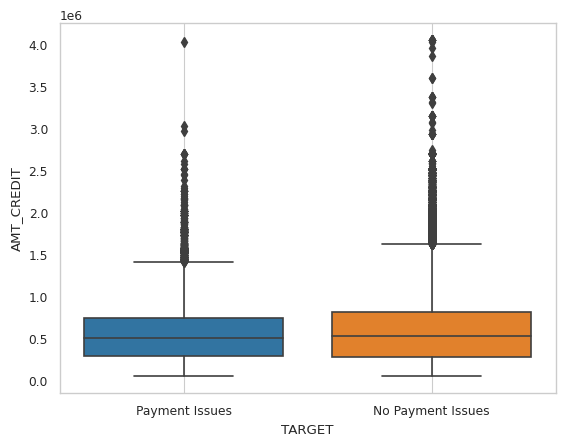

In [33]:
sns.boxplot(x='TARGET', y='AMT_CREDIT',data = train)
plt.grid()
plt.show()

Dapat dilihat bahwa nilai median dari jumlah kredit nasabah yang tidak mengalami kesulitan pembayaran sedikit lebih besar dari nilai median nasabah yang mengalami kesulitan pembayaran. Artinya, nasabah dengan jumlah kredit yang lebih tinggi memiliki peluang sedikit lebih tinggi untuk dapat melunasi pinjaman dibandingkan nasabah dengan jumlah kredit yang lebih rendah.

####Amount Income vs Target

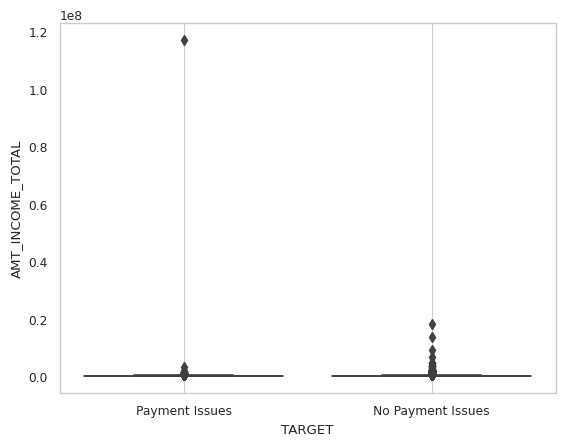

In [34]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL',data = train)
plt.grid()
plt.show()

Dapat dilihat bahwa baik nasabah yang mengalami kesulitan pembayaran maupun nasabah yang tidak mengalami kesulitan pembayaran, sebagian besar memiliki nilai yang sama. Namun, seiring dengan meningkatnya pendapatan nasabah, probabilitas nasabah yang tidak mengalami kesulitan dalam membayar pinjaman juga meningkat.

####Age vs Target

In [35]:
no_age = df_train[df_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df_train[df_train['TARGET']==1]['DAYS_BIRTH'].values/-365

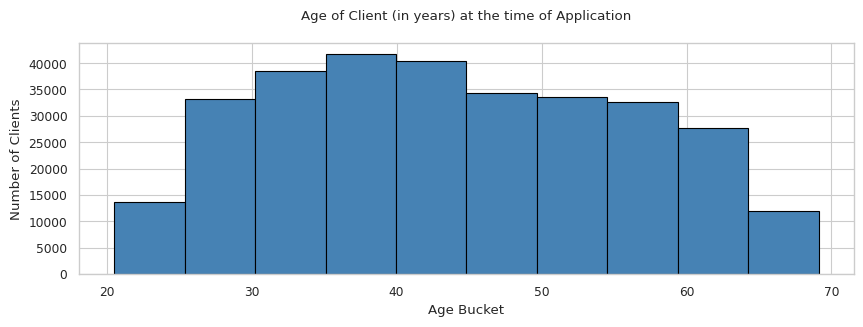

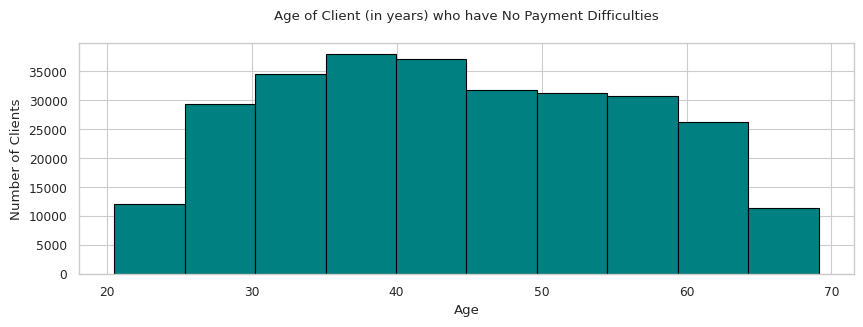

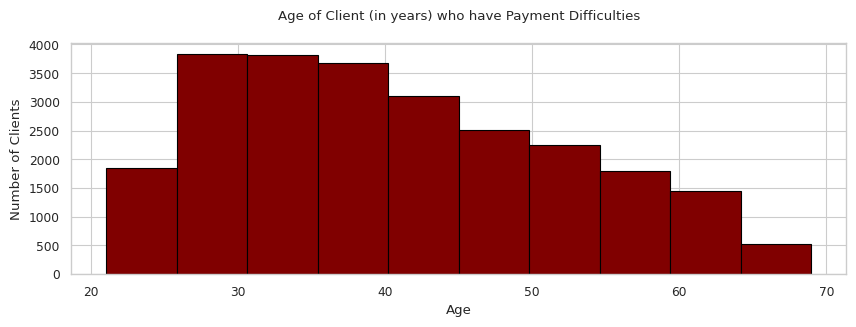

In [36]:
plt.figure(figsize=(10,3))
plt.hist(df_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()


Sebagian besar nasabah yang mengajukan pinjaman berusia antara 35-40 tahun, diikuti oleh nasabah berusia antara 40-45 tahun. Sementara itu, jumlah pemohon untuk nasabah yang berusia <25 tahun atau usia >65 tahun sangat rendah.


Klien yang tidak mengalami kesulitan pembayaran adalah klien dengan rentang usia 35-45 tahun. Sedangkan klien yang mengalami kesulitan pembayaran adalah klien dengan rentang usia 25-35 tahun.

###Multivariat Visualization

Grouped by Realty Ownership Status

####**1. Car Ownership Status, The Number of Children, Target, and Realty Ownership Status**



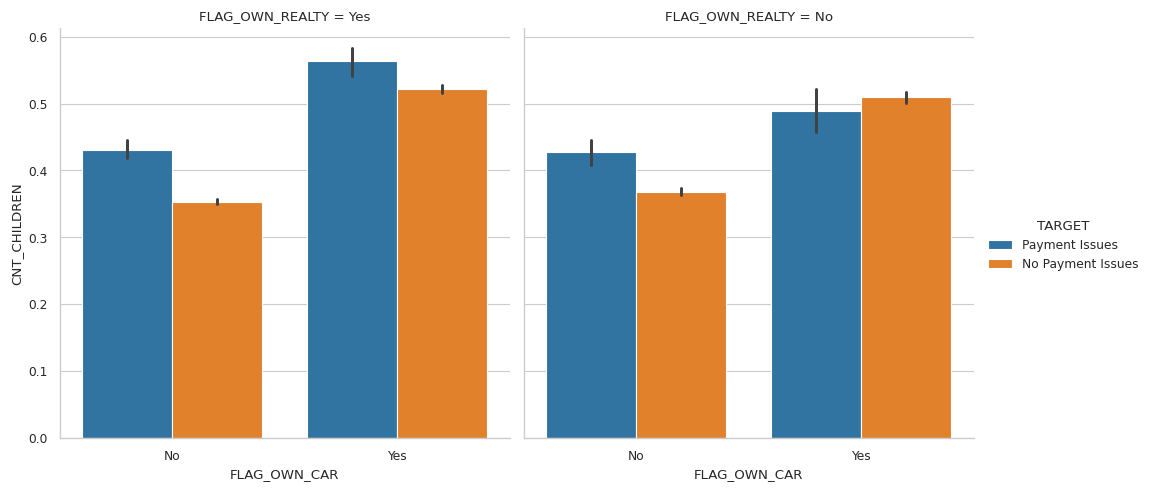

In [37]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN',
            hue = 'TARGET',
            col = 'FLAG_OWN_REALTY',
            kind = 'bar',
            data = train)
plt.show()

Nasabah yang memiliki mobil dan rumah/apartemen memiliki masalah dalam membayar pinjaman karena jumlah anak yang lebih banyak dibandingkan dengan nasabah yang tidak memiliki rumah/apartemen.

####**2. Income Type, Amount of Goods Price, Target, and House/Flat Ownership Status**



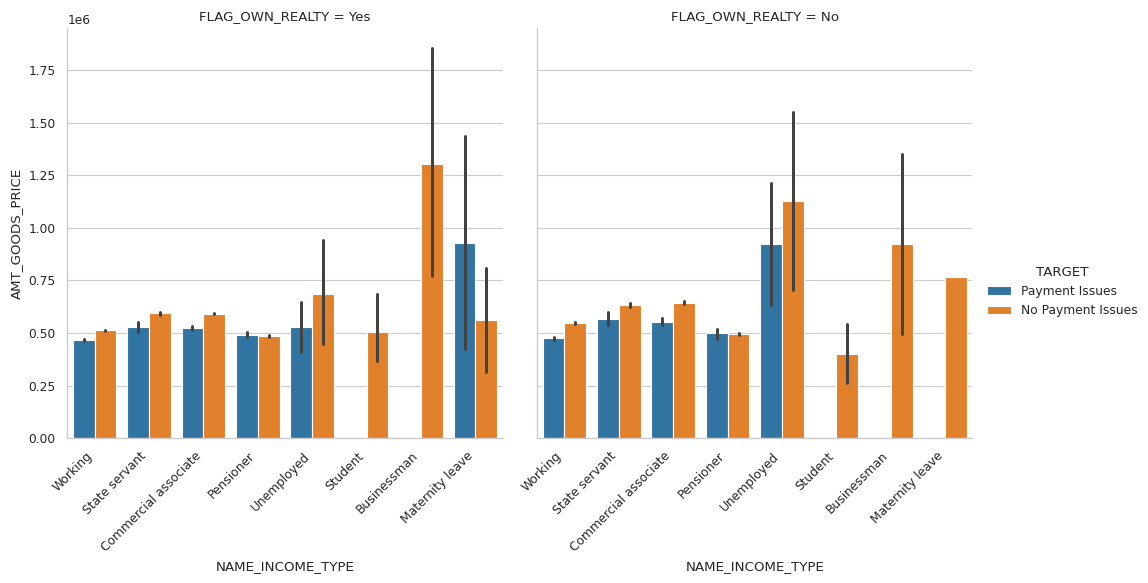

In [38]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE',
            hue = 'TARGET',
            col = 'FLAG_OWN_REALTY',
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Nasabah dengan jenis pendapatan cuti melahirkan pada FLAG_OWN_REALTY = Ya (yaitu memiliki rumah/apartemen) memiliki masalah dalam melunasi pinjaman dibandingkan dengan nasabah dengan jenis pendapatan FLAG_OWN_REALTY = Tidak (yaitu tidak memiliki rumah/apartemen).


####**3.Family Status, Amount of Income, Target, and House/Flat Ownership Status**



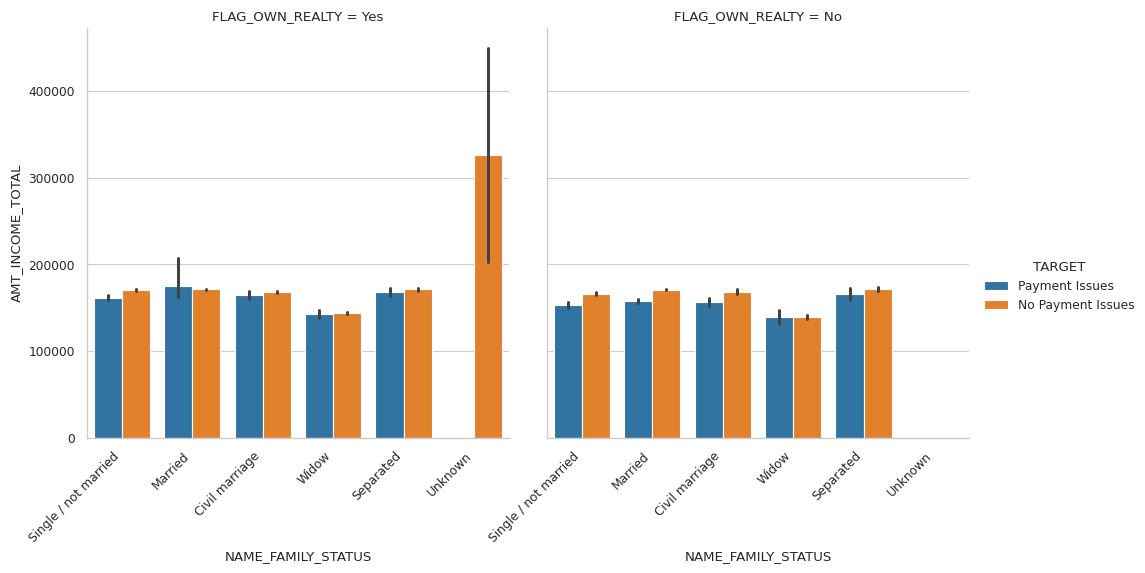

In [39]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL',
            hue = 'TARGET',
            col = 'FLAG_OWN_REALTY',
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Nasabah yang sudah menikah dan memiliki rumah/apartemen (FLAG_MILIK_RUMAH = Ya) memiliki masalah dalam melunasi pinjaman dengan pendapatan menengah dibandingkan dengan nasabah yang tidak memiliki rumah/apartemen (FLAG_MILIK_APARTEMEN = Tidak).

Grouped by Car Ownership Status

####**1. Contract Type, The Number of Children, Target, and Car Ownership Status**


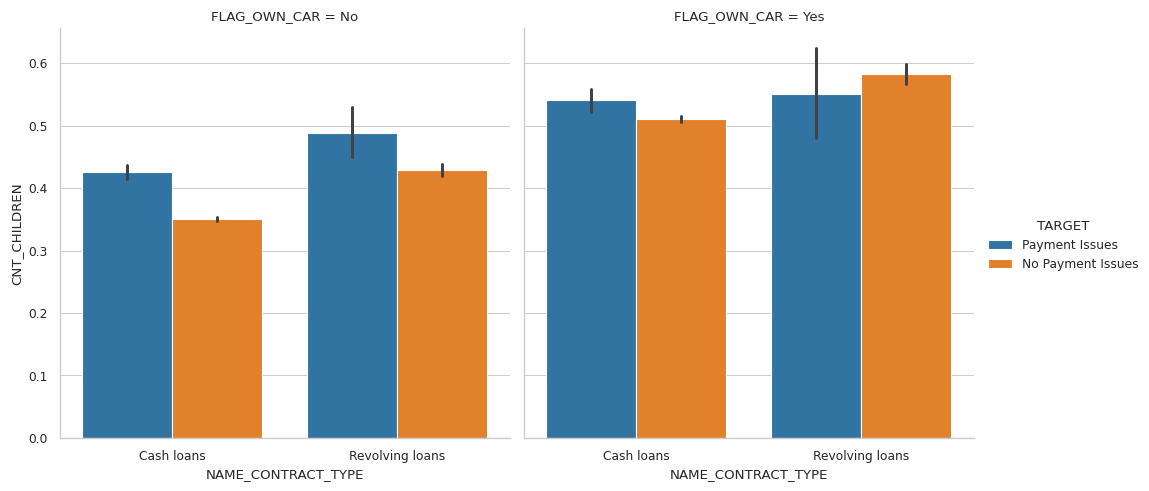

In [40]:
sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'CNT_CHILDREN',
            hue = 'TARGET',
            col = 'FLAG_OWN_CAR',
            kind = 'bar',
            data = train)
plt.show()

Untuk pinjaman bergulir dengan kondisi FLAG_MEMILIKI_MOBIL = Tidak (tidak memiliki mobil) lebih sulit untuk melunasi pinjaman dibandingkan dengan kondisi FLAG_MEMILIKI_MOBIL = Ya (memiliki mobil).

Grouped by Contract Type


####**1. Income Type, Amount of Credit, Target, and Contract Type**

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'NAME_CONTRACT_TYPE',
            kind = 'bar',palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

Untuk jenis pendapatan **maternity leave** dengan **cash loans tunai**, semua nasabah memiliki masalah dalam membayar pinjaman untuk jumlah kredit menengah. Sementara semua nasabah dengan cuti melahirkan dan pinjaman bergulir tidak mengalami kesulitan dalam membayar pinjaman.

Untuk nasabah yang **unemployed** dengan **cash loans**, lebih dari 50% nasabah mengalami masalah dalam membayar pinjaman dengan jumlah kredit menengah. Sementara semua nasabah yang menganggur dengan pinjaman bergulir tidak mengalami kesulitan untuk membayar pinjaman.

Semua nasabah **student** tidak mengalami kesulitan dalam membayar pinjaman baik dengan pinjaman tunai maupun pinjaman bergulir dengan jumlah kredit rendah hingga menengah.

Grouped by Rating of Region where Client Lives


####**1. Housing Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

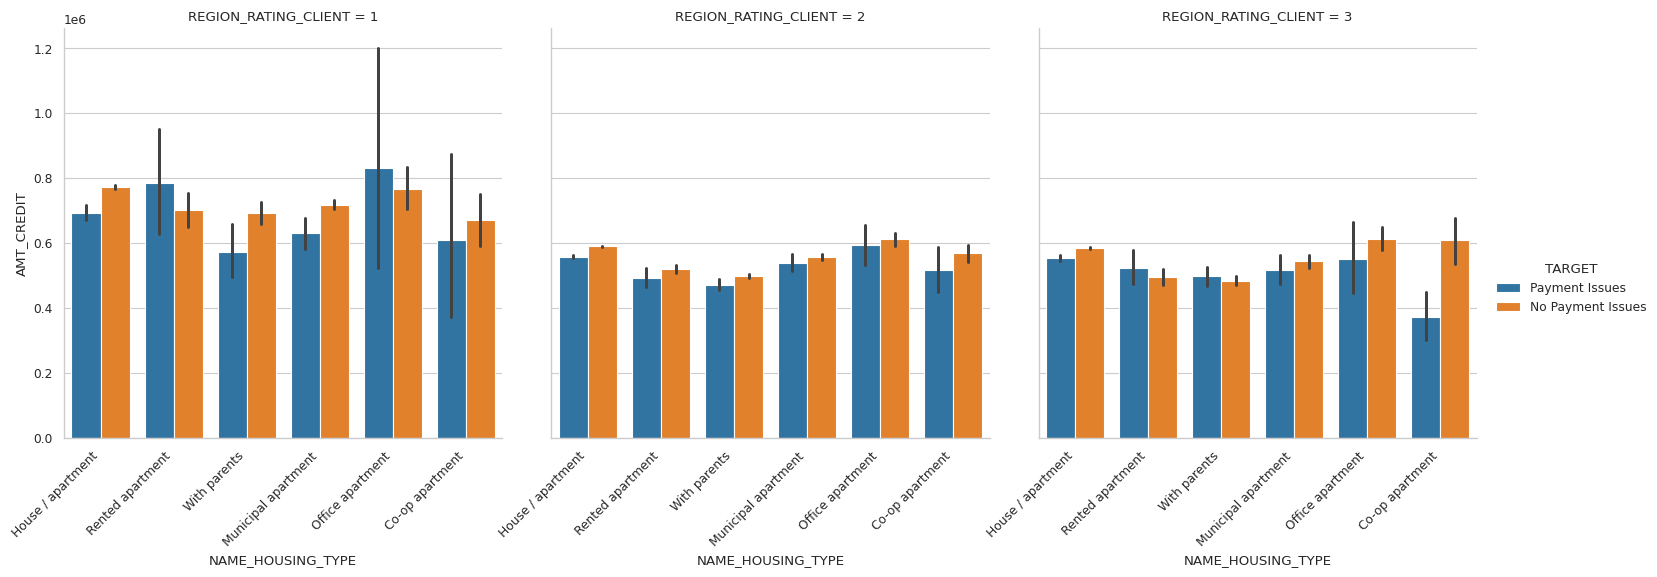

In [42]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Nasabah yang tinggal di **rented apartment** dan **office apartment** dan wilayah mereka memiliki peringkat 1, memiliki masalah dalam membayar pinjaman dibandingkan dengan nasabah di wilayah dengan peringkat 2 untuk jumlah kredit menengah.


####**2. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives**


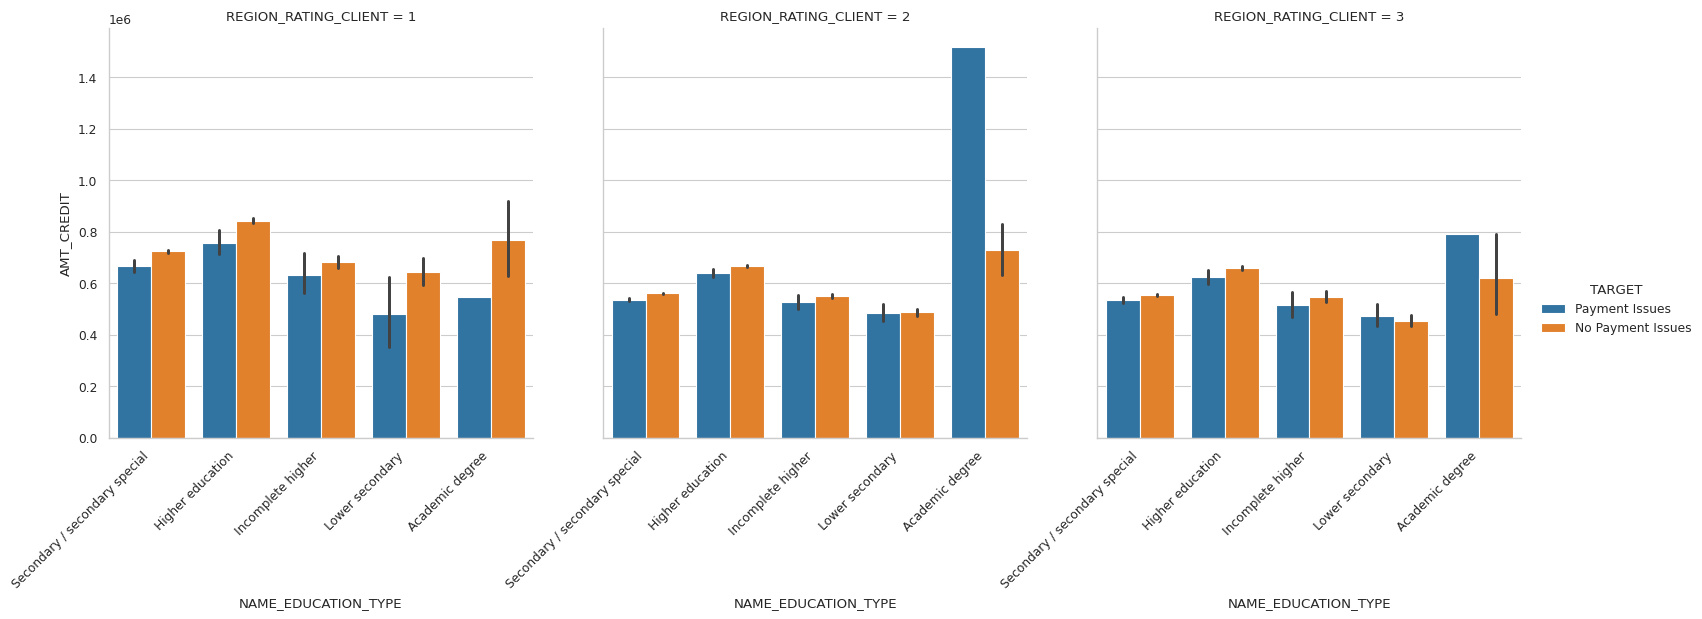

In [43]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Untuk nasabah yang memiliki **academic degree** dan tinggal di wilayah dengan **rating of 2**, memiliki masalah dalam membayar pinjaman untuk jumlah kredit yang lebih tinggi dari pinjaman tersebut. Dan, nasabah dengan gelar yang sama tetapi tinggal di wilayah dengan peringkat 3 memiliki masalah dalam membayar pinjaman untuk jumlah kredit pinjaman menengah.

####**3. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

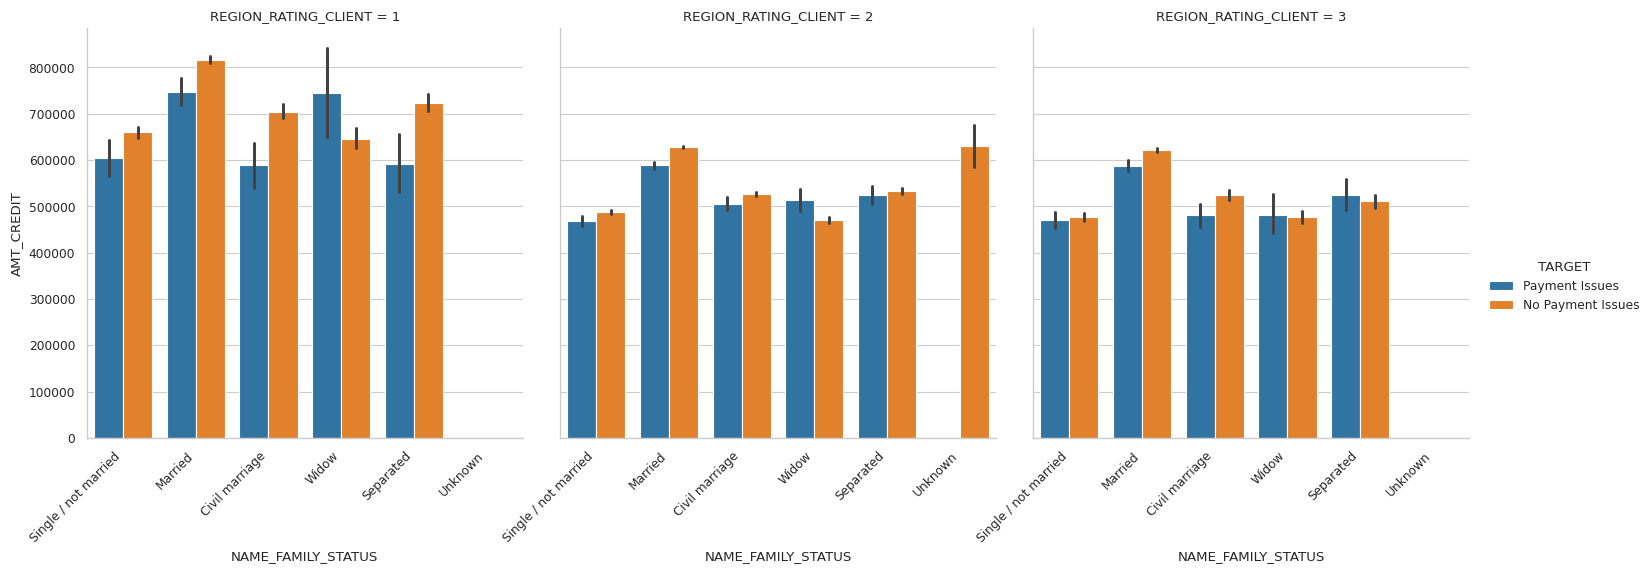

In [44]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Nasabah yang memiliki status keluarga sebagai **widow**, baik yang tinggal di wilayah dengan peringkat 1, 2, atau 3, memiliki masalah dalam membayar pinjaman untuk kredit dengan jumlah sedang hingga tinggi.

Nasabah yang memiliki status keluarga sebagai **separated**, dan tinggal di daerah dengan peringkat 3, memiliki masalah dalam membayar pinjaman untuk jumlah pinjaman yang sedang dibandingkan dengan nasabah yang tinggal di daerah dengan peringkat 1 atau 2.

##Data Cleansing

###Detecting Data Duplication


In [45]:
df_train.duplicated().sum()

0

###Detecting Missing Values

In [46]:
# check for empty elements
nvc = pd.DataFrame(df_train.isnull().sum(), columns=['Total Missing Values'])
nvc['Percentage'] = (nvc['Total Missing Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

,index,Total Missing Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


Drop feature / kolom yang memiliki missing values sebesar 50% lebih

In [47]:
df_train.drop(df_train.iloc[:, 44:91], inplace=True, axis=1)
df_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [48]:
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
7,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
8,NAME_TYPE_SUITE,1292,0.420148
9,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021


<Axes: xlabel='AMT_REQ_CREDIT_BUREAU_DAY', ylabel='Density'>

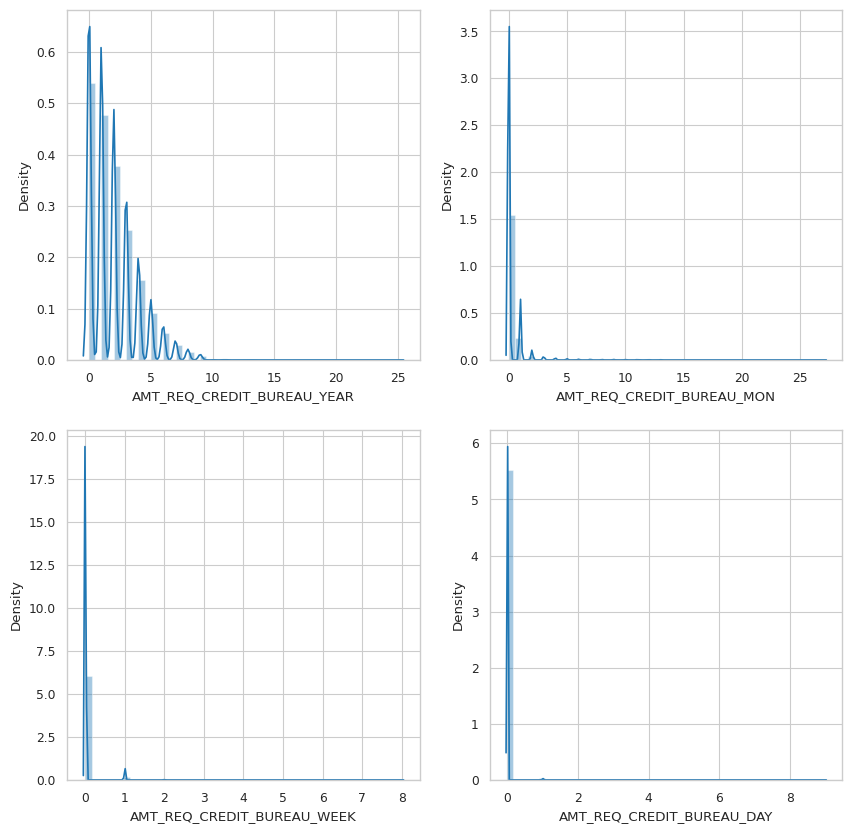

In [49]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])

<Axes: xlabel='AMT_ANNUITY', ylabel='Density'>

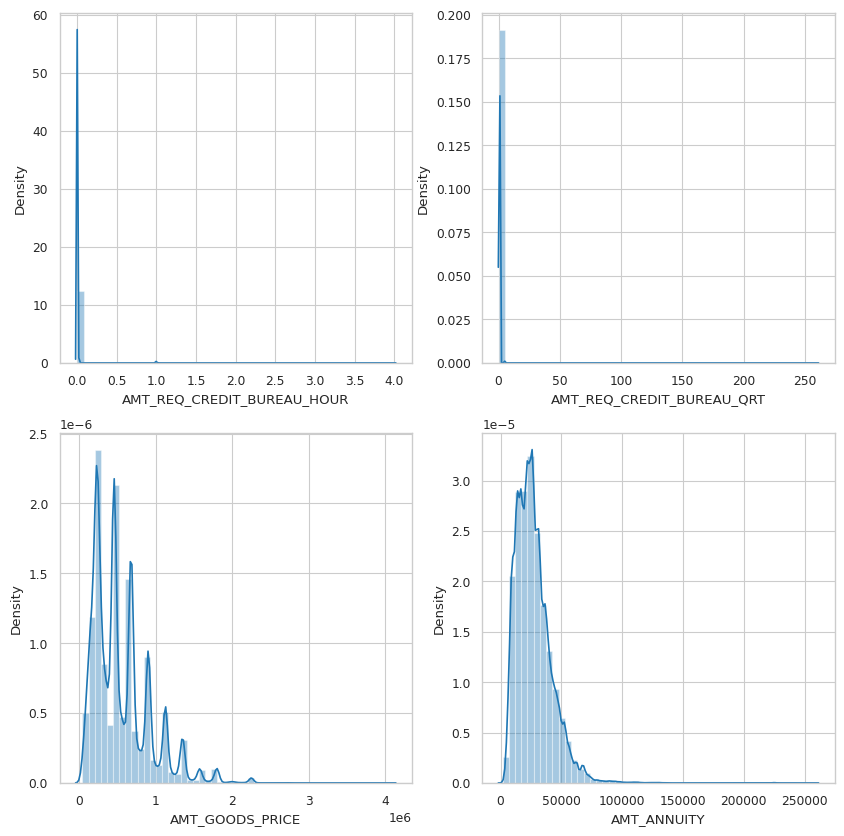

In [50]:
# distribution of numerical features that have missing values pt.2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])

sns.distplot(df_train['AMT_GOODS_PRICE'], ax=ax[1][0])

sns.distplot(df_train['AMT_ANNUITY'], ax=ax[1][1])

<Axes: xlabel='OBS_30_CNT_SOCIAL_CIRCLE', ylabel='Density'>

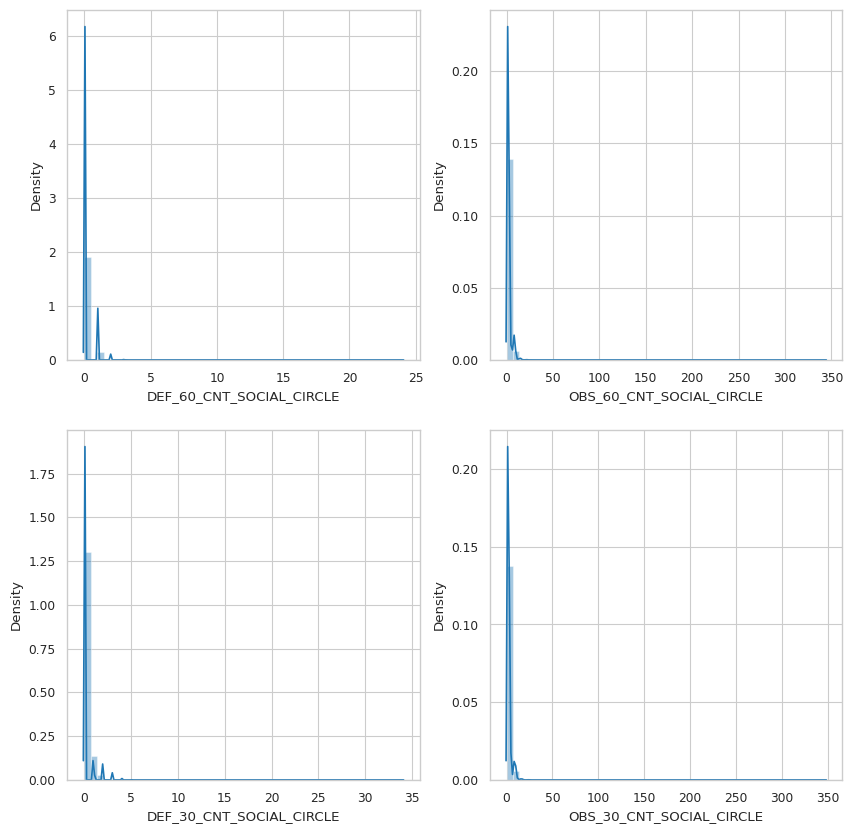

In [51]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(df_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(df_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(df_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

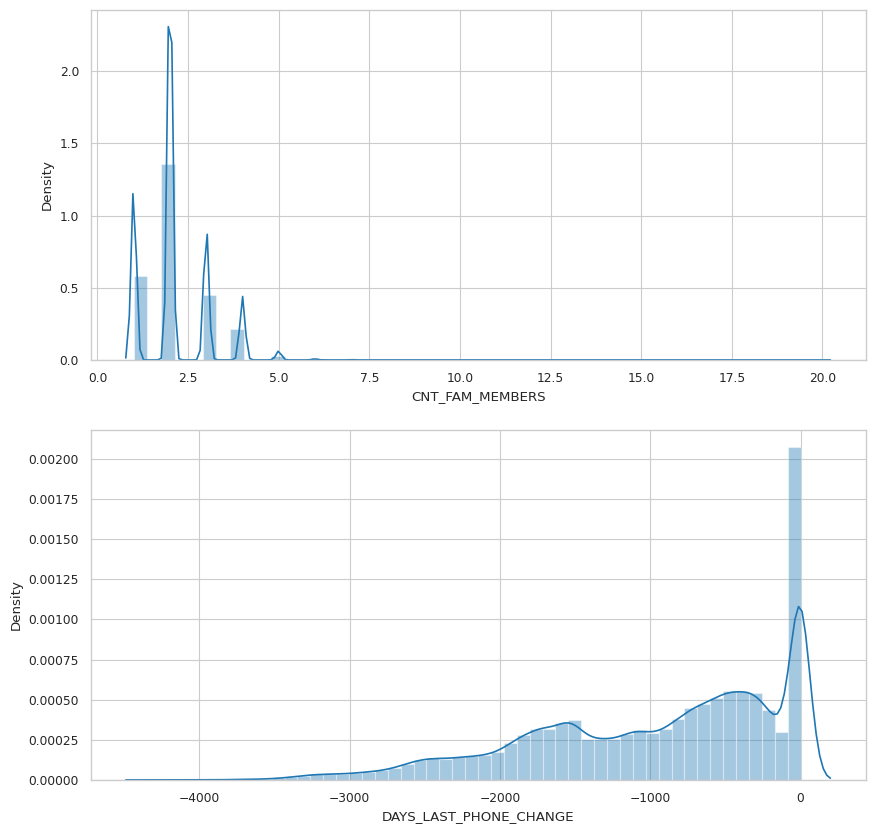

In [52]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['CNT_FAM_MEMBERS'], ax=ax[0])

sns.distplot(df_train['DAYS_LAST_PHONE_CHANGE'], ax=ax[1])

Dapat dilihat bahwa distribusi fitur numerik yang disebutkan di atas miring, sehingga nilai yang hilang pada fitur-fitur tersebut akan diperhitungkan dengan median.

In [53]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_train.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_train.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_train:
    if df_train[column].isnull().any():
        if(column in category_columns):
            df_train[column]=df_train[column].fillna(df_train[column].mode()[0])
        else:
            df_train[column]=df_train[column].fillna(df_train[column].median())

In [54]:
# after imputation
print('Missing values status:', df_train.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
5,NAME_CONTRACT_TYPE,0,0.0
6,CODE_GENDER,0,0.0
7,FLAG_OWN_CAR,0,0.0
8,FLAG_OWN_REALTY,0,0.0
9,CNT_CHILDREN,0,0.0


###Detecting Outliers

In [55]:
int_features = df_train[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]


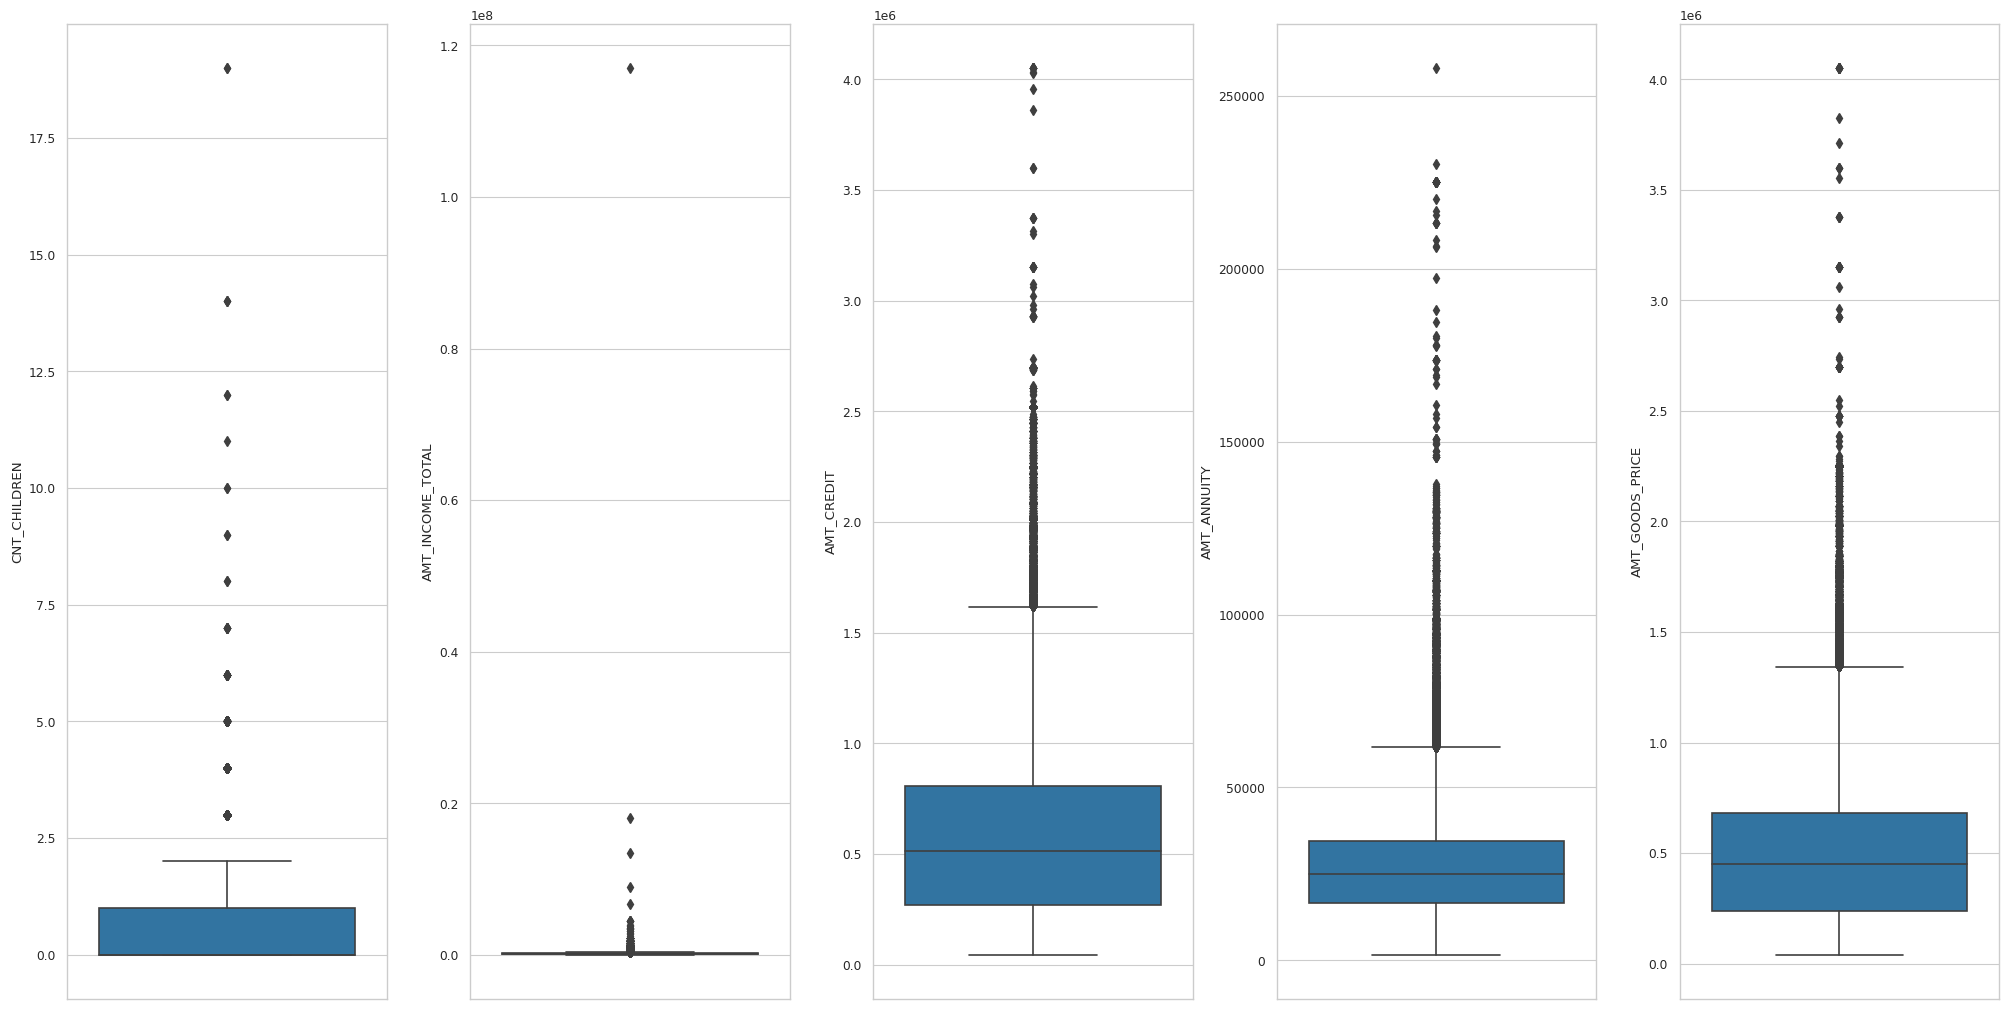

In [56]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [57]:
int_features = df_train[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

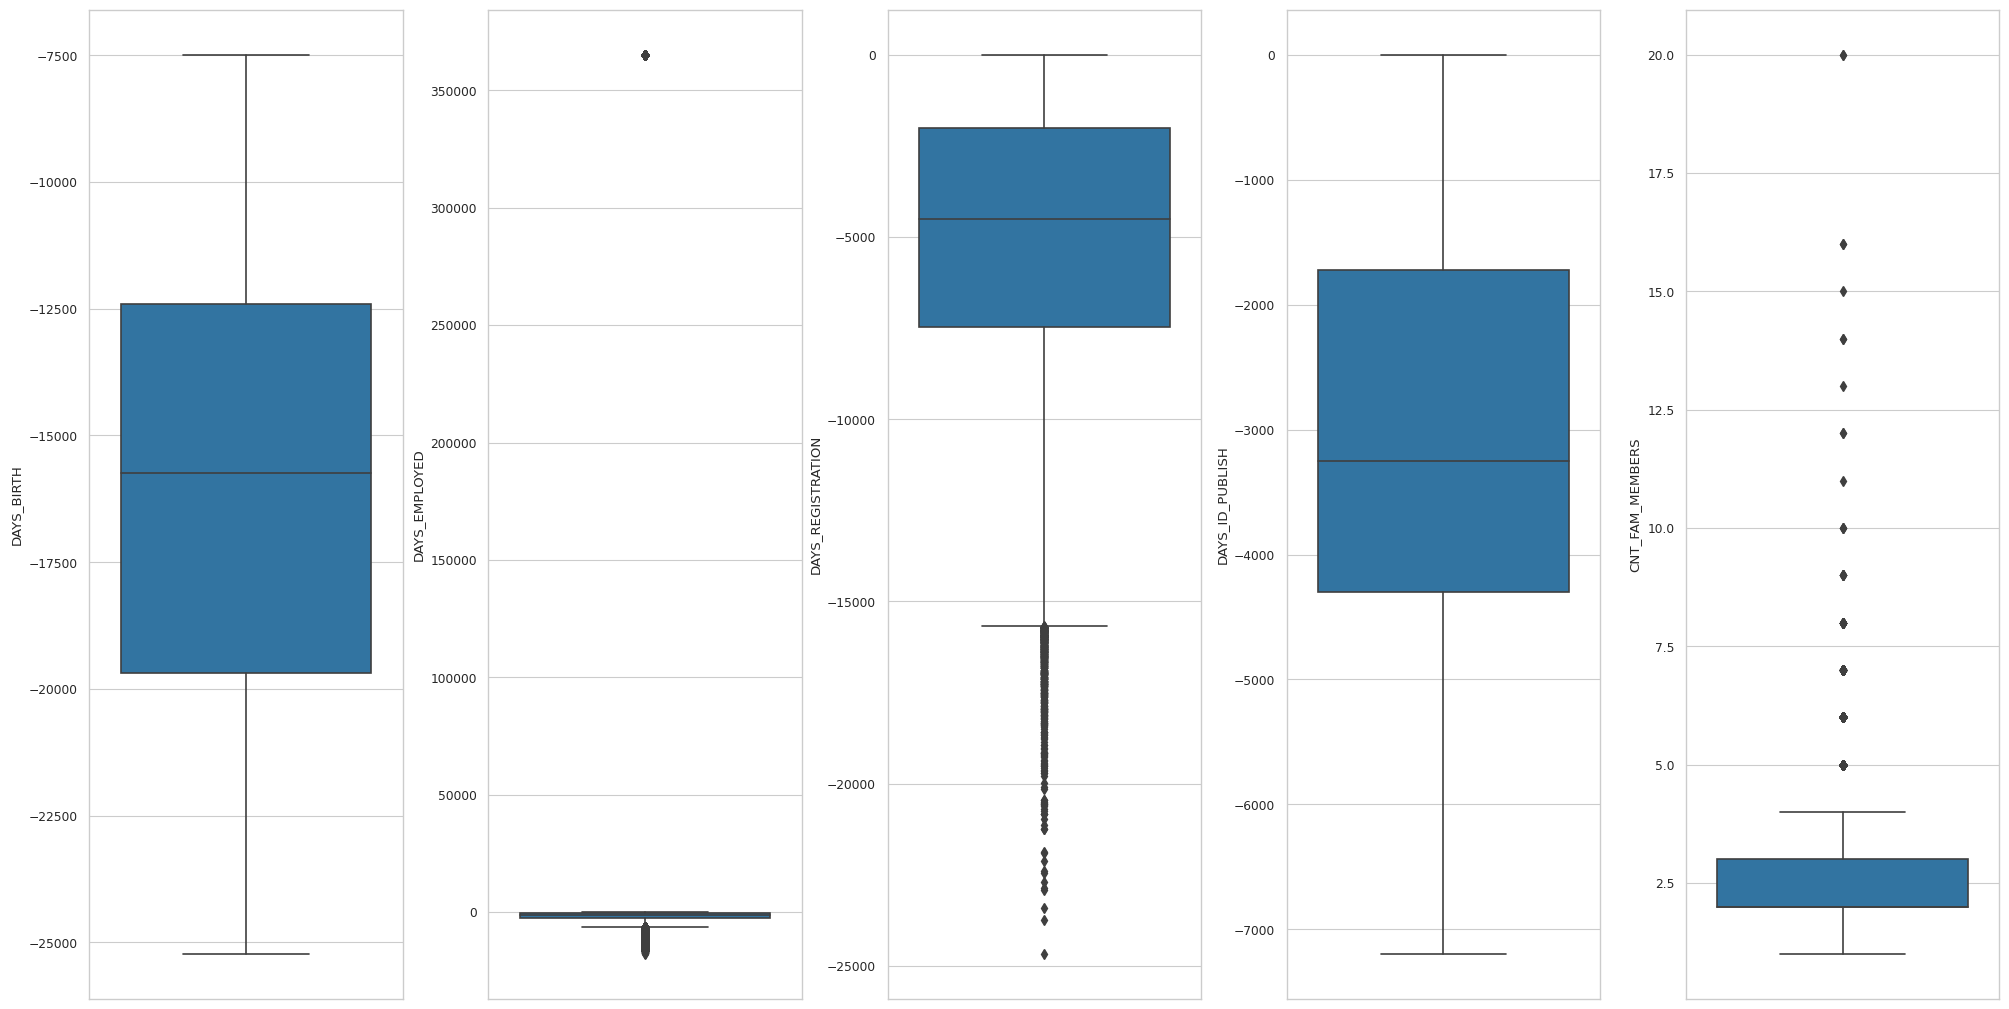

In [58]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [59]:
int_features = df_train[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]


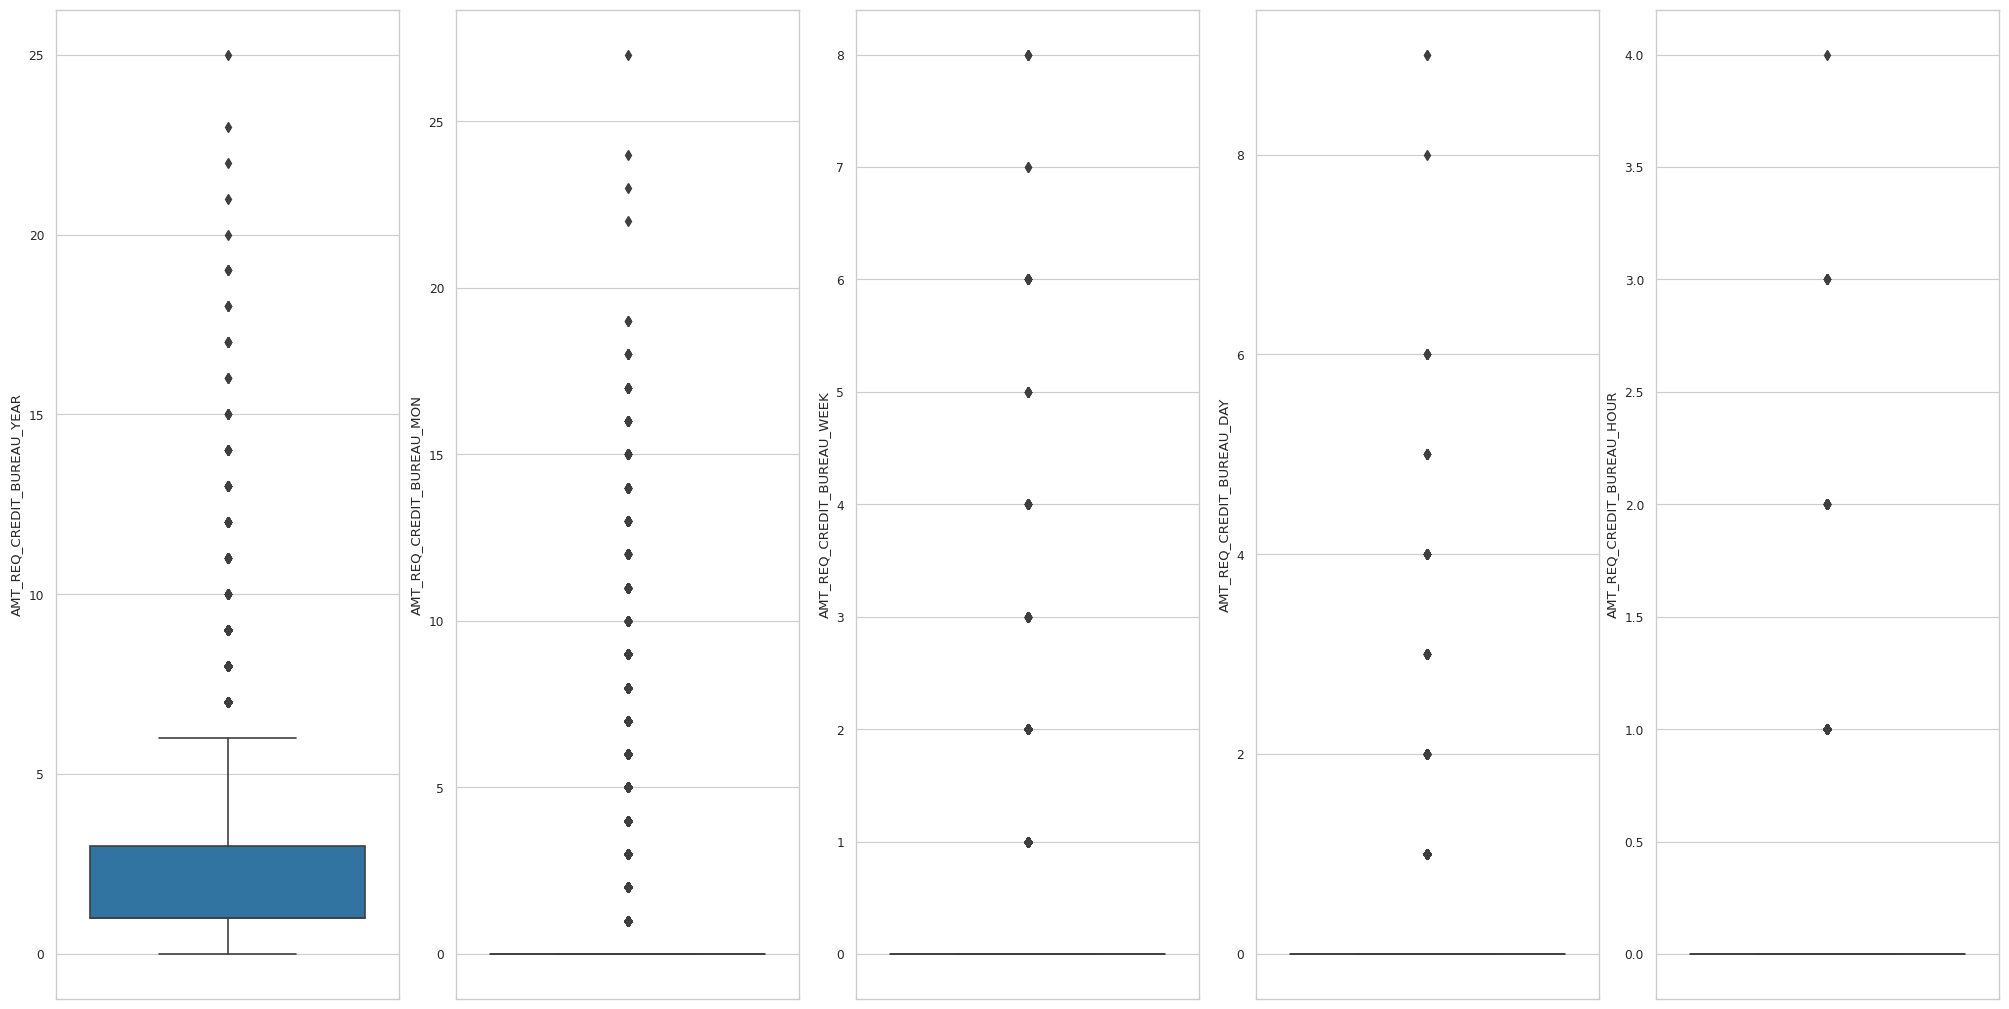

In [60]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [61]:
int_features = df_train[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]


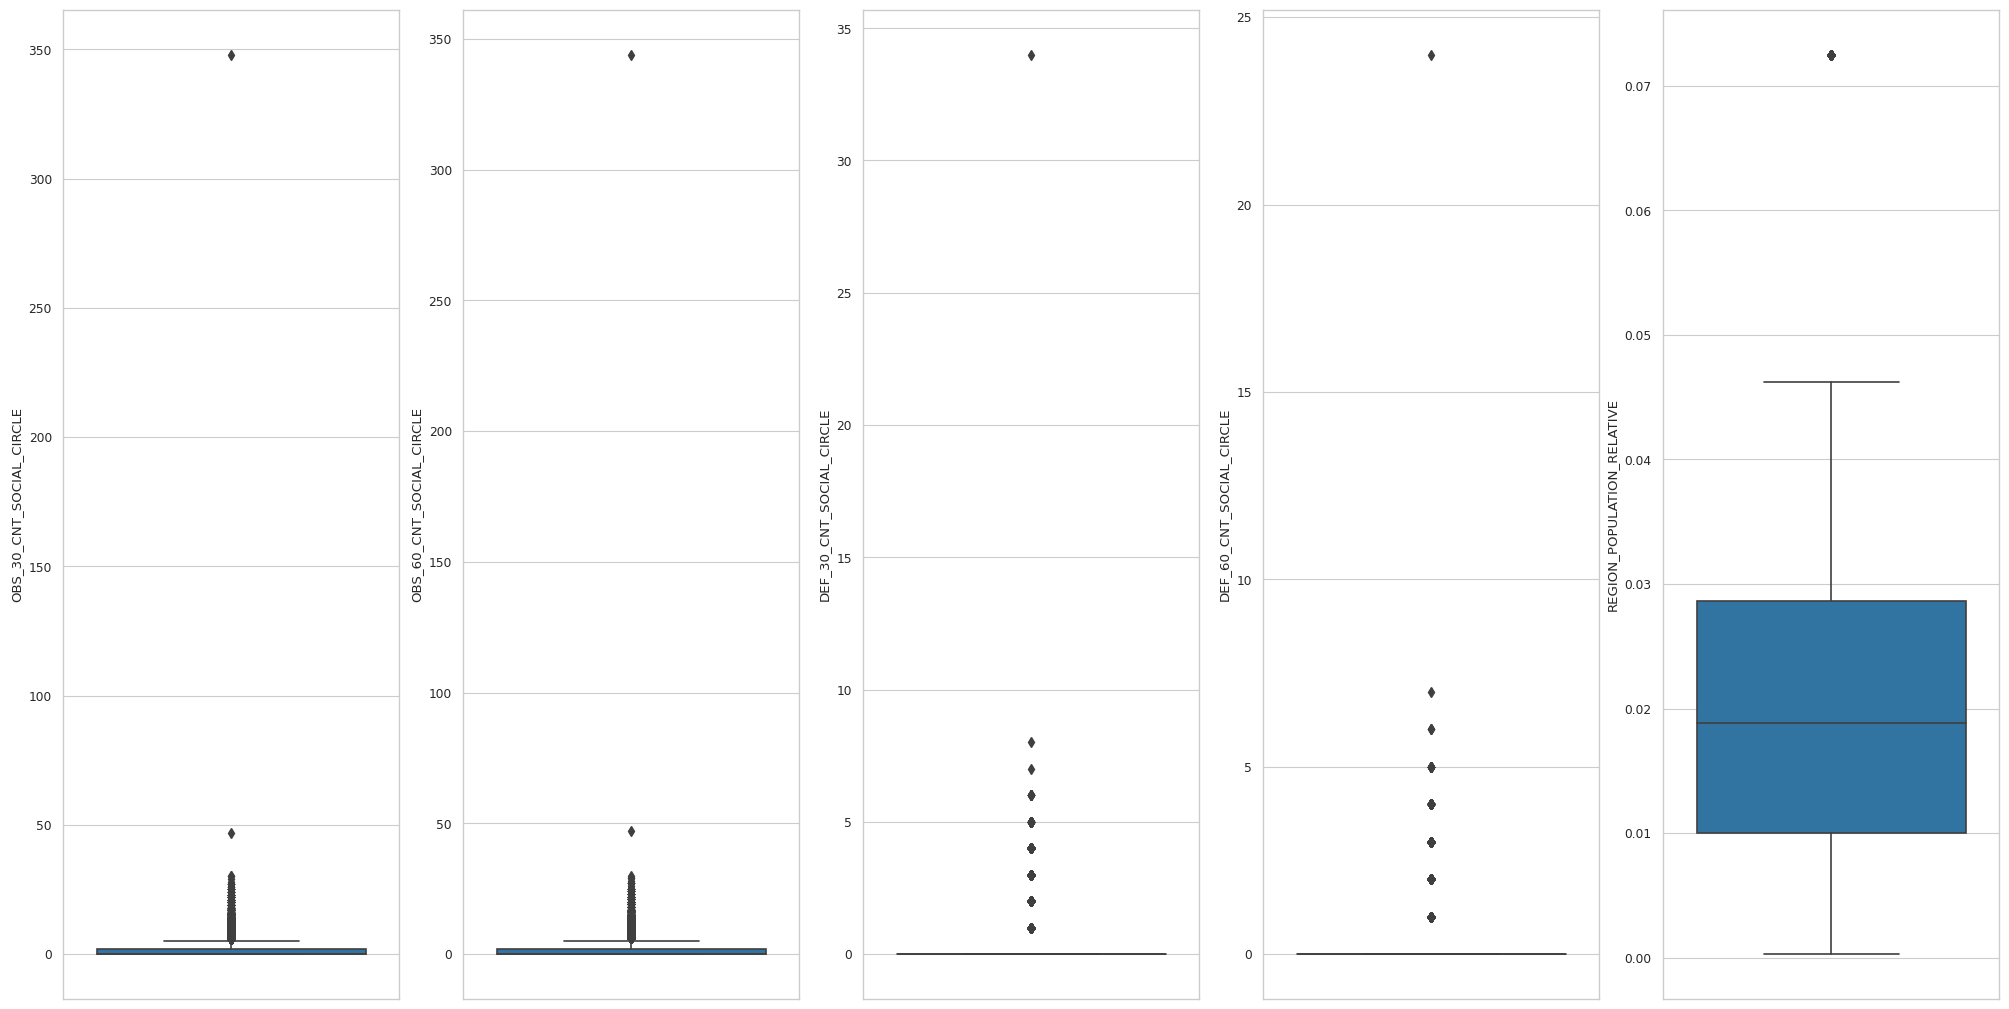

In [62]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [63]:
int_features = df_train[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]


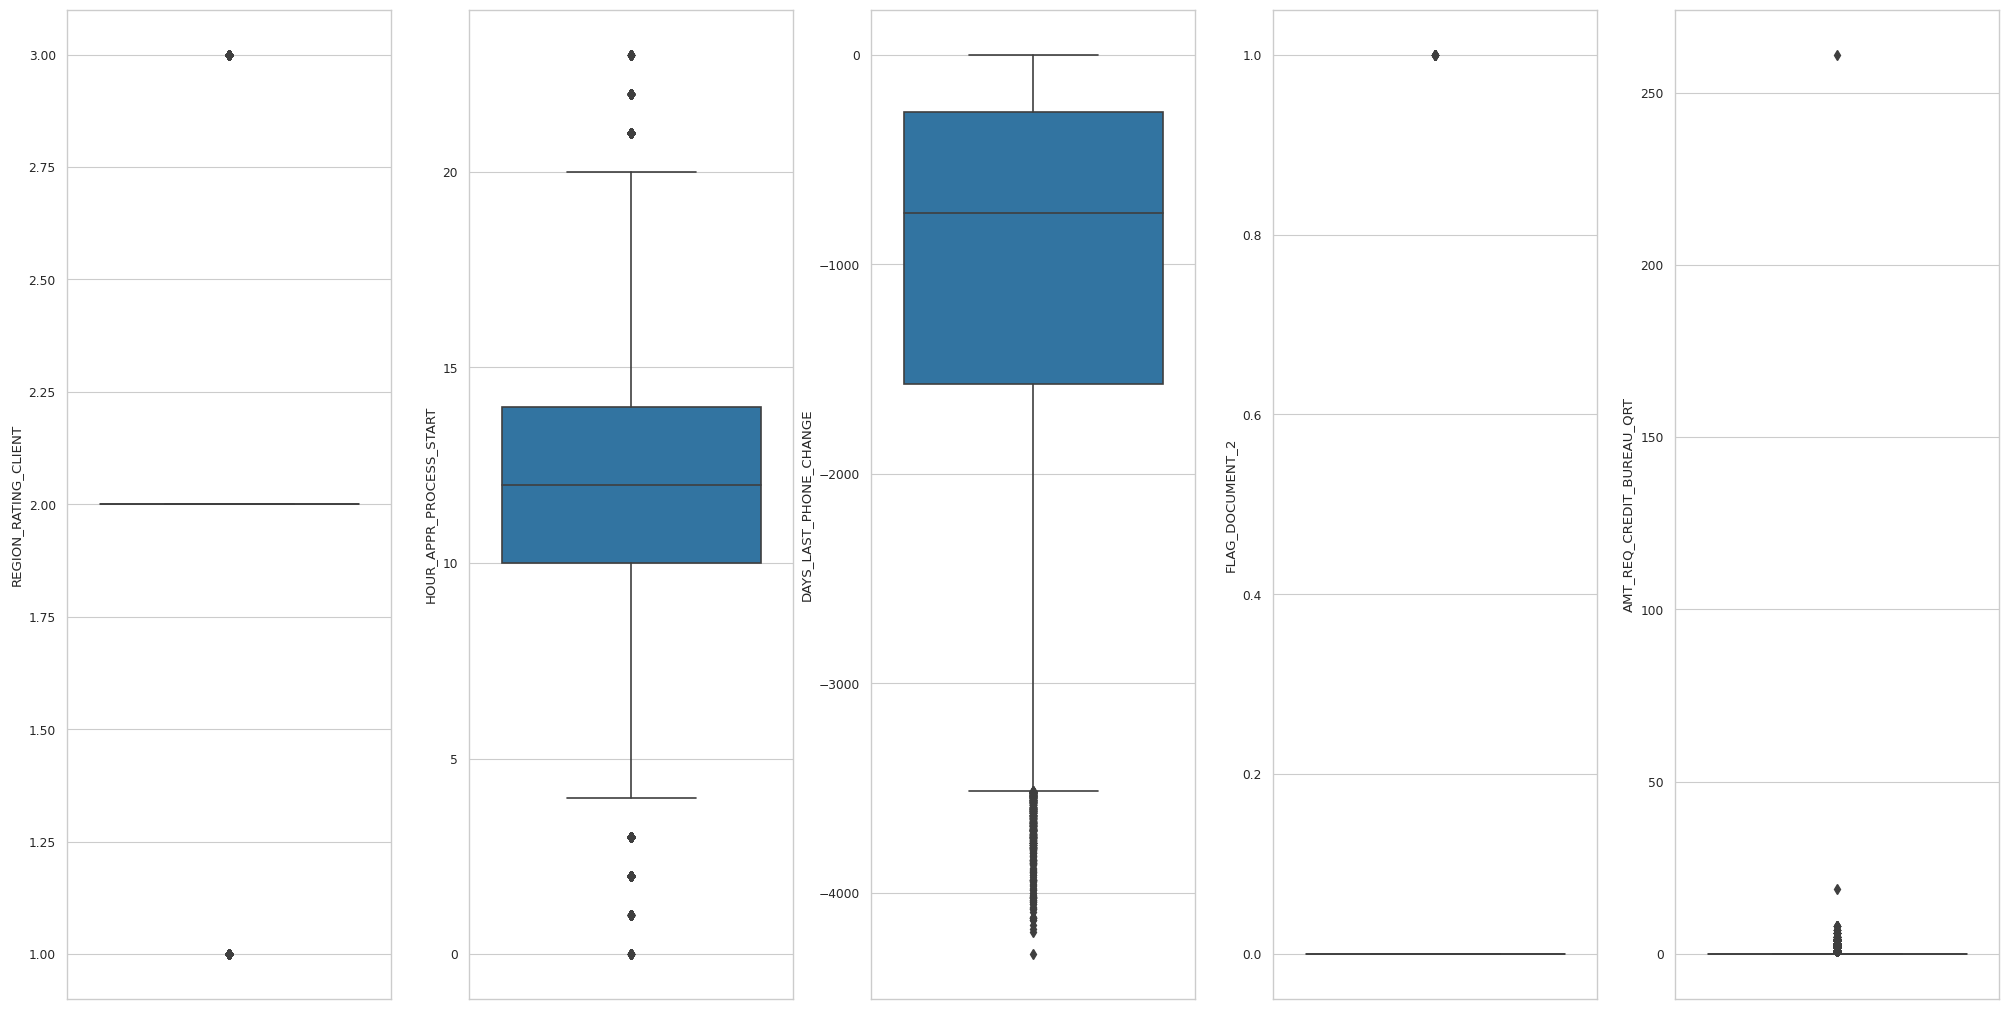

In [64]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


##Machine Learning Models

###Label Encoding

In [65]:
df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [66]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


###Feature Selection

####**Drop Unnecessary Feature / Column**

In [67]:
df_train.drop(['SK_ID_CURR'], inplace=True, axis=1)

In [68]:
df_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


####**Convert Negative Values to Positive Values**

Fitur yang memiliki nilai negatif adala `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, `DAYS_REGISTRATION`, dan `DAYS_LAST_PHONE_CHANGE`



In [69]:
df_train.iloc[:,16:20] = df_train.iloc[:,16:20].abs()
df_train.iloc[:,45] = df_train.iloc[:,45].abs()

####Feature Selection from target



In [70]:
x = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

In [71]:
# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
17,DAYS_REGISTRATION,1.348566e+06
44,DAYS_LAST_PHONE_CHANGE,6.656876e+05
18,DAYS_ID_PUBLISH,6.195946e+05
7,AMT_ANNUITY,3.913092e+05
37,ORGANIZATION_TYPE,4.138607e+03


Dapat dilihat fitur mana yang berkorelasi dengan baik dengan kesulitan pembayaran.
Best features: `DAYS_EMPLOYED`, `AMT_GOODS_PRICE`, and `AMT_CREDIT`

Worst features: `FLAG_MOBIL`, `FLAG_CONT_MOBILE`, and `AMT_REQ_CREDIT_BUREAU_HOUR`

##Auto ML

##Handling Data Imbalance

###**Oversampling**

In [77]:
# create two different dataframe of majority and minority class
df_majority = df_train[(df_train['TARGET']==0)]
df_minority = df_train[(df_train['TARGET']==1)]

# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples= 282686, # to match majority class
                                 random_state=42)  # reproducible results

# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

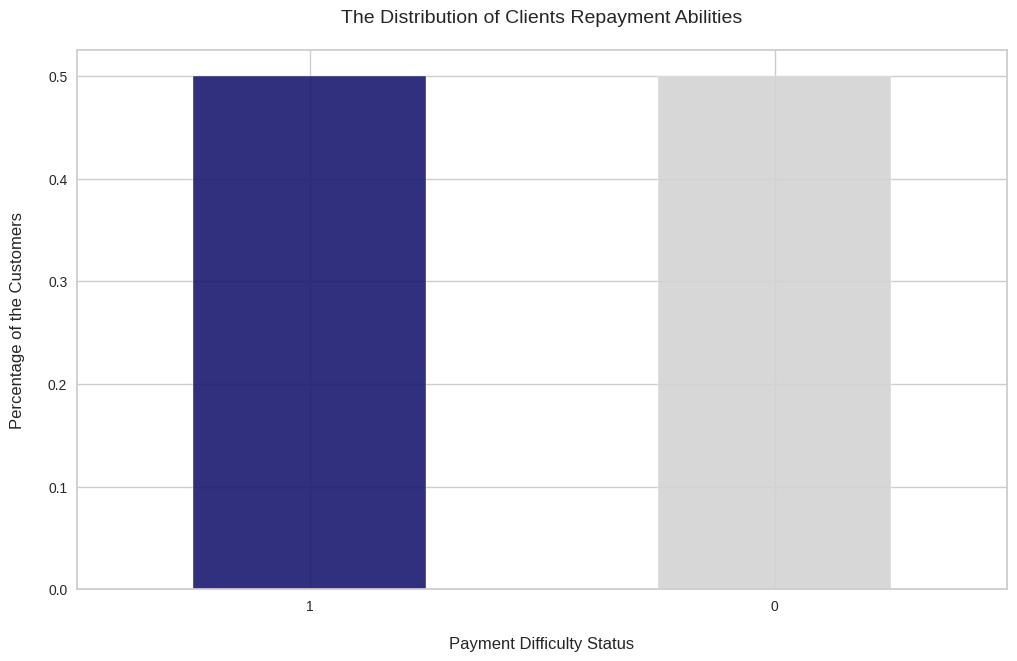

In [78]:
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

##Data Splitting

In [84]:
# define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY',
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [85]:
# splitting tha data
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(452297, 20) (113075, 20)


In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

##Model Building

###LogisticRegression

In [94]:
log_model = LogisticRegression().fit(X_train, y_train)
# predict data train
y_train_pred_log = log_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



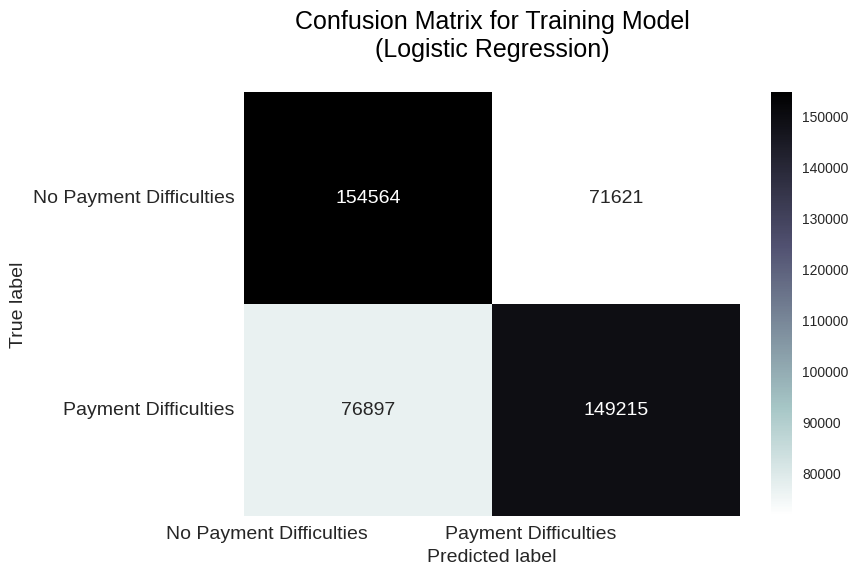

In [95]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [96]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



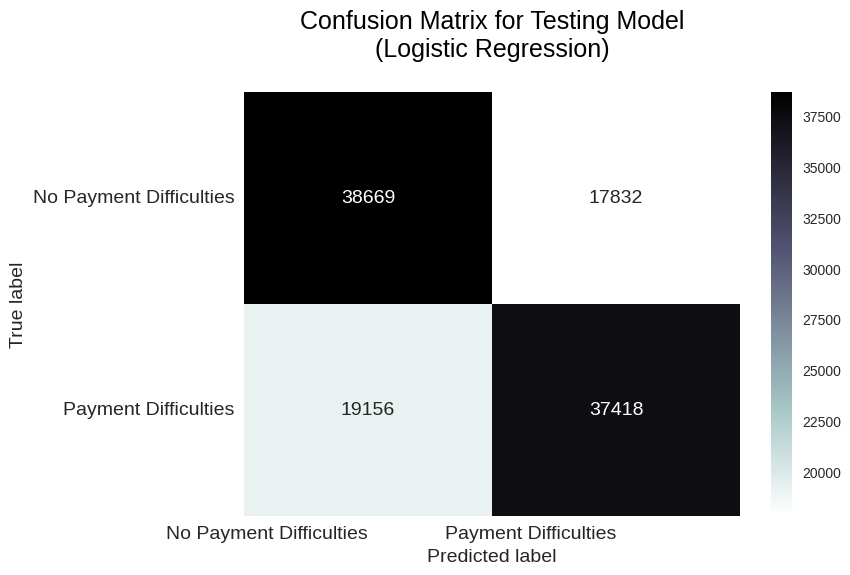

In [97]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [98]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


###Train with Lightgbm model

In [103]:
model = ltb.LGBMClassifier()
model.fit(X_train, y_train)
print(); print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)

[LightGBM] [Info] Number of positive: 226112, number of negative: 226185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2852
[LightGBM] [Info] Number of data points in the train set: 452297, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499919 -> initscore=-0.000323
[LightGBM] [Info] Start training from score -0.000323

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [93]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70     56501
           1       0.71      0.65      0.67     56574

    accuracy                           0.69    113075
   macro avg       0.69      0.69      0.69    113075
weighted avg       0.69      0.69      0.69    113075

[[41342 15159]
 [20032 36542]]


#Prediction

##Import Dataset

In [104]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Terdapat total 48.744 baris yang berisi informasi pinjaman dan terdapat 121 fitur (tanpa fitur target).

##Data Preprocessing

####Check Duplication

In [105]:
print('The number of duplication is:', df_test.duplicated().sum())
# there is no duplication


The number of duplication is: 0


###Detecting Missing Values

In [106]:
# check for empty elements
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_AVG,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_AVG,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
5,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
6,FONDKAPREMONT_MODE,32797,67.284179
7,LIVINGAPARTMENTS_AVG,32780,67.249302
8,LIVINGAPARTMENTS_MODE,32780,67.249302
9,LIVINGAPARTMENTS_MEDI,32780,67.249302


In [107]:
# drop features that have large number of missing values (± 50%)
df_test.drop(df_test.iloc[:, 43:90], inplace=True, axis=1)
df_test.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [108]:
# after drop some features
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
5,AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.409732
6,AMT_REQ_CREDIT_BUREAU_DAY,6049,12.409732
7,AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.409732
8,NAME_TYPE_SUITE,911,1.868948
9,OBS_30_CNT_SOCIAL_CIRCLE,29,0.059495


In [109]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [110]:
# after imputation
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,NAME_CONTRACT_TYPE,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
5,FLAG_DOCUMENT_5,0,0.0
6,FLAG_DOCUMENT_4,0,0.0
7,FLAG_DOCUMENT_3,0,0.0
8,FLAG_DOCUMENT_2,0,0.0
9,DAYS_LAST_PHONE_CHANGE,0,0.0


###Label Encoding

In [111]:
# label encoder for object features
df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [112]:
df_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,6,6,1,1,1,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,8,2.0,2,2,5,18,0,0,0,0,0,0,28,0.789654,0.159520,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,6,6,4,1,1,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,9,2.0,2,2,0,9,0,0,0,0,0,0,42,0.291656,0.432962,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,6,6,1,1,1,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,4,2.0,2,2,1,14,0,0,0,0,0,0,54,0.699787,0.610991,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,6,6,4,1,1,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,14,4.0,2,2,6,11,0,0,0,0,0,0,5,0.509677,0.612704,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,6,6,4,1,1,0.010032,-13040,-2191,-4000.0,-4262,1,1,1,1,0,0,8,3.0,2,2,0,5,0,0,0,0,1,1,5,0.425687,0.519097,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


###Convert Negative Values to Positive Values


Fitur yang meiliki nilai negatif `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, dan `DAYS_REGISTRATION`, `DAYS_LAST_PHONE_CHANGE`



In [113]:
df_test.iloc[:,16:20] = df_test.iloc[:,16:20].abs()
df_test.iloc[:,45] = df_test.iloc[:,45].abs()

#Test Prediction

In [114]:
pred_test = df_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY',
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()

,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,2329,450000.0,568800.0,19241,135000.0,5170.0,1740.0,812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,4469,180000.0,222768.0,18064,99000.0,9118.0,0.0,1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,4458,630000.0,663264.0,20038,202500.0,2175.0,856.0,3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,1866,1575000.0,1575000.0,13976,315000.0,2000.0,1805.0,4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,2191,625500.0,625500.0,13040,180000.0,4000.0,821.0,4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


In [115]:
# lets predict!
predict = pd.Series(log_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

,SK_ID_CURR,TARGET
0,100001,1
1,100005,1
2,100013,0
3,100028,0
4,100038,0


In [122]:
# Let's predict wih lgbbm
predict = pd.Series(model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
